In [260]:
#!pip install scikit-optimize
#!pip install lightgbm
#!pip install tensorflow

In [261]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn import tree
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import lightgbm as lgb
from lightgbm import LGBMClassifier
import logging
from sklearn.svm import SVC
import time

In [262]:
file_path = 'SBA_tisztitott.csv'
df_sba=pd.read_csv(file_path, parse_dates=['ApprovalDate','DisbursementDate'])
df_sba.head()

Name          City State    Zip  \
0                 ABC HOBBYCRAFT    EVANSVILLE    IN  47711   
1    LANDMARK BAR & GRILLE (THE)     NEW PARIS    IN  46526   
2          WHITLOCK DDS, TODD M.   BLOOMINGTON    IN  47401   
3  BIG BUCKS PAWN & JEWELRY, LLC  BROKEN ARROW    OK  74012   
4    ANASTASIA CONFECTIONS, INC.       ORLANDO    FL  32801   

                            Bank BankState  NAICS ApprovalDate  ApprovalFY  \
0               FIFTH THIRD BANK        OH     45   1997-02-28        1997   
1                1ST SOURCE BANK        IN     72   1997-02-28        1997   
2        GRANT COUNTY STATE BANK        IN     62   1997-02-28        1997   
3  1ST NATL BK & TR CO OF BROKEN        OK      0   1997-02-28        1997   
4        FLORIDA BUS. DEVEL CORP        FL      0   1997-02-28        1997   

   Term  NoEmp  NewExist  CreateJob  RetainedJob  UrbanRural  RevLineCr  \
0    84      4         2          0            0           0      False   
1    60      2         2          0            0           0      False   
2   180      7         1          0            0           0      False   
3    60      2         1          0            0           0      False   
4   240     14         1          7            7           0      False   

   LowDoc ChgOffDate DisbursementDate  DisbursementGross  BalanceGross  \
0    True        NaN       1999-02-28            60000.0           0.0   
1    True        NaN       1997-05-31            40000.0           0.0   
2   False        NaN       1997-12-31           287000.0           0.0   
3    True        NaN       1997-06-30            35000.0           0.0   
4   False        NaN       1997-05-14           229000.0           0.0   

   ChgOffPrinGr    GrAppv  SBA_Appv  PaidBack  
0           0.0   60000.0   48000.0      True  
1           0.0   40000.0   32000.0      True  
2           0.0  287000.0  215250.0      True  
3           0.0   35000.0   28000.0      True  
4           0.0  229000.0  229000.0      True

In [263]:
def describe_data(df):
    print(len(df_sba))
    column=[]
    d_type=[]
    uniques=[]
    n_uniques=[]
    nan=[]
    d_min=[]
    d_max=[]

    for i in df.columns:
        column.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
        nan.append(df[i].isna().sum()/len(df)*100)
        if df[i].dtype != 'object':
            d_min.append(df[i].min())
        else:
            d_min.append(None)
        if df[i].dtype != 'object':
            d_max.append(df[i].max())
        else:
            d_max.append(None)

    return pd.DataFrame({'Column': column, 'type': d_type, 'unique sample': uniques, 'uniques': n_uniques, 'NaN%': nan, 'Min': d_min, 'Max': d_max})



In [264]:
describe_data(df_sba)

868076


Column            type  \
0                Name          object   
1                City          object   
2               State          object   
3                 Zip           int64   
4                Bank          object   
5           BankState          object   
6               NAICS           int64   
7        ApprovalDate  datetime64[ns]   
8          ApprovalFY           int64   
9                Term           int64   
10              NoEmp           int64   
11           NewExist           int64   
12          CreateJob           int64   
13        RetainedJob           int64   
14         UrbanRural           int64   
15          RevLineCr            bool   
16             LowDoc            bool   
17         ChgOffDate          object   
18   DisbursementDate  datetime64[ns]   
19  DisbursementGross         float64   
20       BalanceGross         float64   
21       ChgOffPrinGr         float64   
22             GrAppv         float64   
23           SBA_Appv         float64   
24           PaidBack            bool   

                                                                                                                                                  unique sample  \
0                              [ABC HOBBYCRAFT, LANDMARK BAR & GRILLE (THE), WHITLOCK DDS, TODD M., BIG BUCKS PAWN & JEWELRY, LLC, ANASTASIA CONFECTIONS, INC.]   
1                                                                                                   [EVANSVILLE, NEW PARIS, BLOOMINGTON, BROKEN ARROW, ORLANDO]   
2                                                                                                                                          [IN, OK, FL, CT, NJ]   
3                                                                                                                           [47711, 46526, 47401, 74012, 32801]   
4                                          [FIFTH THIRD BANK, 1ST SOURCE BANK, GRANT COUNTY STATE BANK, 1ST NATL BK & TR CO OF BROKEN, FLORIDA BUS. DEVEL CORP]   
5                                                                                                                                          [OH, IN, OK, FL, DE]   
6                                                                                                                                           [45, 72, 62, 0, 33]   
7   [1997-02-28T00:00:00.000000000, 1980-06-02T00:00:00.000000000, 2006-02-07T00:00:00.000000000, 1980-06-11T00:00:00.000000000, 1996-10-04T00:00:00.000000000]   
8                                                                                                                                [1997, 1980, 2006, 1998, 1999]   
9                                                                                                                                       [84, 60, 180, 240, 120]   
10                                                                                                                                            [4, 2, 7, 14, 19]   
11                                                                                                                                                       [2, 1]   
12                                                                                                                                             [0, 7, 30, 5, 4]   
13                                                                                                                                             [0, 7, 23, 4, 6]   
14                                                                                                                                                    [0, 1, 2]   
15                                                                                                                                                [False, True]   
16                                                                                                                                                [True, False]   
17            

In [265]:
df_sba = df_sba.drop(columns=['ChgOffDate'])

In [266]:
df_sba['DisbursementGross'] = df_sba['DisbursementGross'].astype('int64')
df_sba['BalanceGross'] = df_sba['BalanceGross'].astype('int64')
df_sba['ChgOffPrinGr'] = df_sba['ChgOffPrinGr'].astype('int64')
df_sba['GrAppv'] = df_sba['GrAppv'].astype('int64')
df_sba['SBA_Appv'] = df_sba['SBA_Appv'].astype('int64')
df_sba['PaidBack'] = df_sba['PaidBack'].astype(int)

In [267]:
#nem relevánsak
df_sba = df_sba.drop(columns=['City','Zip','Name','Bank','BankState','ApprovalDate','ApprovalFY','DisbursementDate'],axis=1)

In [268]:
#nem ismerhetjük hitelkérelem elbírálása során
df_sba = df_sba.drop(columns=['BalanceGross','ChgOffPrinGr','GrAppv'],axis=1)

In [269]:
len(df_sba[df_sba.NAICS==0])

197201

In [270]:
df_sba=df_sba[df_sba.NAICS!=0]

In [271]:
len(df_sba[df_sba.UrbanRural==0])

140245

In [272]:
df_sba=df_sba[df_sba.UrbanRural!=0]

In [273]:
describe_data(df_sba)

530630


Column    type                           unique sample  \
0               State  object                    [NC, AR, CA, FL, LA]   
1               NAICS   int64                    [44, 72, 61, 23, 53]   
2                Term   int64                  [162, 126, 83, 84, 60]   
3               NoEmp   int64                        [2, 7, 18, 4, 3]   
4            NewExist   int64                                  [2, 1]   
5           CreateJob   int64                        [0, 5, 4, 1, 20]   
6         RetainedJob   int64                        [0, 23, 4, 6, 1]   
7          UrbanRural   int64                                  [1, 2]   
8           RevLineCr    bool                           [False, True]   
9              LowDoc    bool                           [False, True]   
10  DisbursementGross   int64  [253400, 137300, 438541, 51440, 50000]   
11           SBA_Appv   int64   [190050, 116705, 50000, 17500, 42500]   
12           PaidBack   int32                                  [1, 0]   

    uniques  NaN%    Min       Max  
0        51   0.0   None      None  
1        24   0.0     11        92  
2       337   0.0      0       569  
3       406   0.0      0      8000  
4         2   0.0      1         2  
5       204   0.0      0      5085  
6       310   0.0      0      9500  
7         2   0.0      1         2  
8         2   0.0  False      True  
9         2   0.0  False      True  
10   102287   0.0   4000  11446325  
11    18817   0.0    500   4500000  
12        2   0.0      0         1

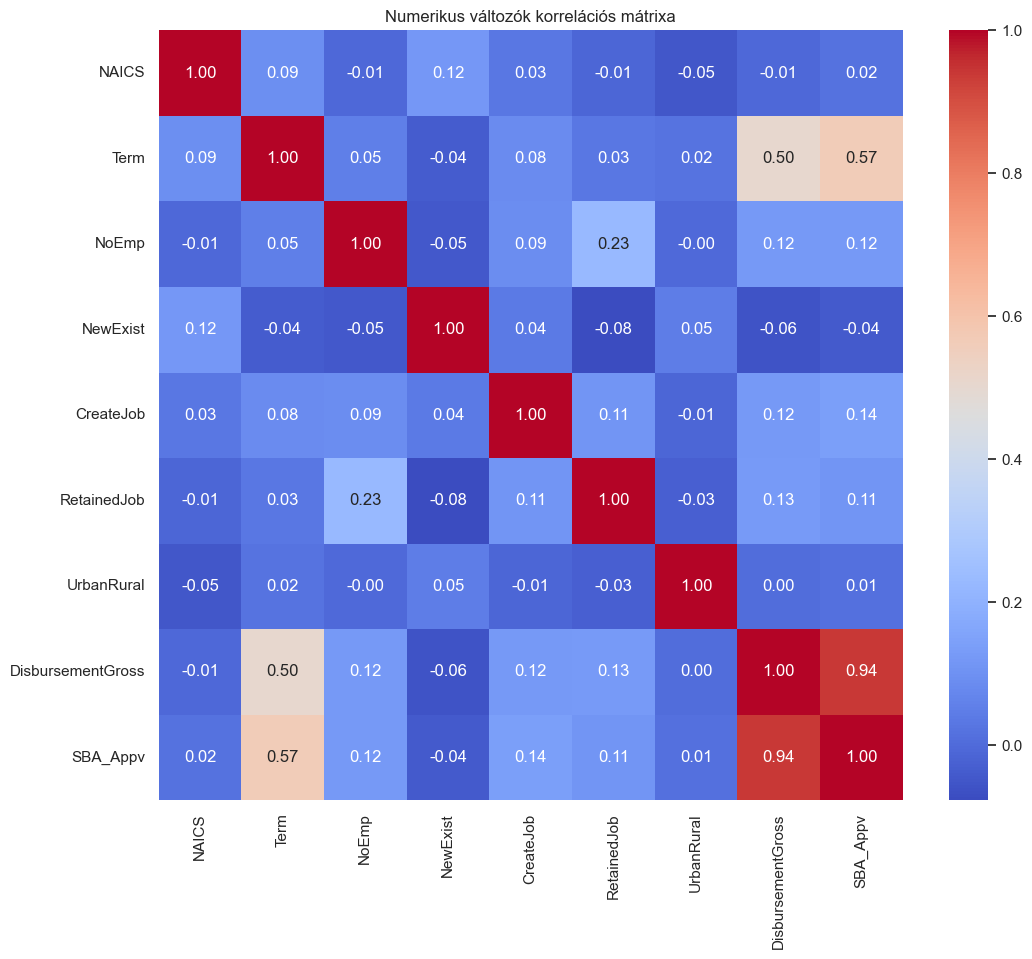

In [274]:
numeric_columns = df_sba.select_dtypes(include=['int64']).columns
correlation_matrix = df_sba[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Numerikus változók korrelációs mátrixa')
plt.show()

In [275]:
df_sba['UrbanRural'] = df_sba['UrbanRural'].replace({2: 0, 1: 1})
df_sba['NewExist'] = df_sba['NewExist'].replace({2: 1, 1: 0})
df_sba['RevLineCr'] = df_sba['RevLineCr'].replace({True: 1, False: 0})
df_sba['LowDoc'] = df_sba['LowDoc'].replace({True: 1, False: 0})

In [276]:
correlation_data = []
continuous_variables = ['Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'DisbursementGross', 'SBA_Appv']
binary_variables=['UrbanRural','NewExist','RevLineCr','LowDoc','PaidBack']
for binary_variable in binary_variables:
    print(f"{binary_variable}")
    for continuous_variable in continuous_variables:
        correlation_coefficient, p_value = pointbiserialr(df_sba[binary_variable], df_sba[continuous_variable])
        print(f"\t{continuous_variable}: {correlation_coefficient:.2f}, p érték: {p_value:.2f}")
        correlation_data.append({'Binary Variable': binary_variable, 'Continuous Variable': continuous_variable, 'Correlation Coefficient': correlation_coefficient})

UrbanRural
	Term: -0.02, p érték: 0.00
	NoEmp: 0.00, p érték: 0.09
	CreateJob: 0.01, p érték: 0.00
	RetainedJob: 0.03, p érték: 0.00
	DisbursementGross: -0.00, p érték: 0.00
	SBA_Appv: -0.01, p érték: 0.00
NewExist
	Term: -0.04, p érték: 0.00
	NoEmp: -0.05, p érték: 0.00
	CreateJob: 0.04, p érték: 0.00
	RetainedJob: -0.08, p érték: 0.00
	DisbursementGross: -0.06, p érték: 0.00
	SBA_Appv: -0.04, p érték: 0.00
RevLineCr
	Term: -0.35, p érték: 0.00
	NoEmp: -0.04, p érték: 0.00
	CreateJob: -0.05, p érték: 0.00
	RetainedJob: 0.00, p érték: 0.35
	DisbursementGross: -0.21, p érték: 0.00
	SBA_Appv: -0.31, p érték: 0.00
LowDoc
	Term: -0.03, p érték: 0.00
	NoEmp: -0.01, p érték: 0.00
	CreateJob: -0.05, p érték: 0.00
	RetainedJob: -0.07, p érték: 0.00
	DisbursementGross: -0.10, p érték: 0.00
	SBA_Appv: -0.07, p érték: 0.00
PaidBack
	Term: 0.34, p érték: 0.00
	NoEmp: 0.03, p érték: 0.00
	CreateJob: 0.02, p érték: 0.00
	RetainedJob: 0.02, p érték: 0.00
	DisbursementGross: 0.13, p érték: 0.00
	SBA_A

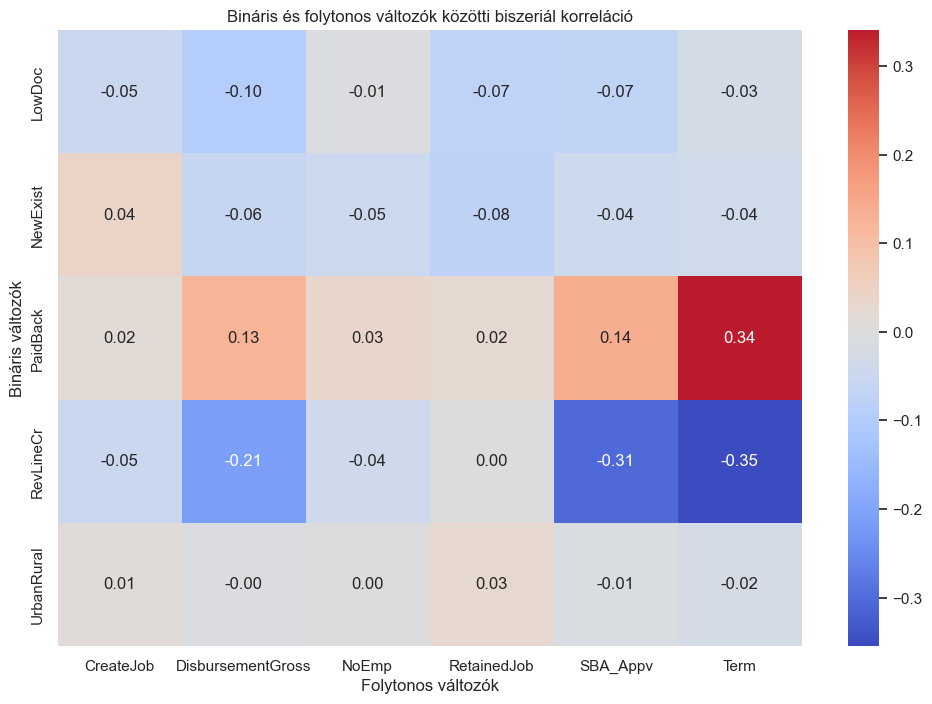

In [277]:
correlation_df = pd.DataFrame(correlation_data)
plt.figure(figsize=(12, 8))
correlation_matrix = correlation_df.pivot(index="Binary Variable", columns="Continuous Variable", values="Correlation Coefficient")
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Bináris és folytonos változók közötti biszeriál korreláció")
plt.xlabel('Folytonos változók')
plt.ylabel('Bináris változók')
plt.show()

In [278]:
df_sba = df_sba.drop(columns=['CreateJob','NoEmp','RetainedJob'],axis=1)

In [279]:
describe_data(df_sba)

530630


Column    type                           unique sample  uniques  \
0              State  object                    [NC, AR, CA, FL, LA]       51   
1              NAICS   int64                    [44, 72, 61, 23, 53]       24   
2               Term   int64                  [162, 126, 83, 84, 60]      337   
3           NewExist   int64                                  [1, 0]        2   
4         UrbanRural   int64                                  [1, 0]        2   
5          RevLineCr   int64                                  [0, 1]        2   
6             LowDoc   int64                                  [0, 1]        2   
7  DisbursementGross   int64  [253400, 137300, 438541, 51440, 50000]   102287   
8           SBA_Appv   int64   [190050, 116705, 50000, 17500, 42500]    18817   
9           PaidBack   int32                                  [1, 0]        2   

   NaN%     Min         Max  
0   0.0     NaN         NaN  
1   0.0    11.0        92.0  
2   0.0     0.0       569.0  
3   0.0     0.0         1.0  
4   0.0     0.0         1.0  
5   0.0     0.0         1.0  
6   0.0     0.0         1.0  
7   0.0  4000.0  11446325.0  
8   0.0   500.0   4500000.0  
9   0.0     0.0         1.0

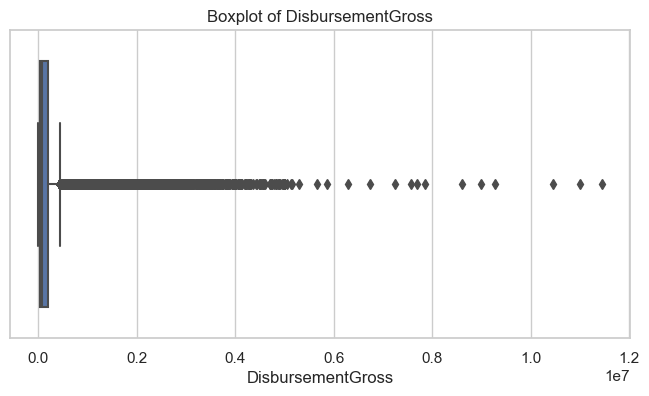

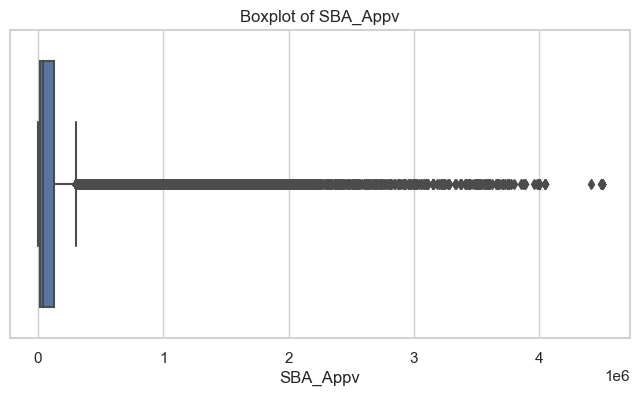

In [280]:
columns = ['DisbursementGross', 'SBA_Appv']
for col in columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_sba[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [281]:
for col in columns:
    Q1=df_sba[col].quantile(0.25)
    Q3=df_sba[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    df_sba = df_sba[(df_sba[col] >= lower_bound) & (df_sba[col] <= upper_bound)]

In [284]:
len(df_sba)

428075

In [285]:
df_sba.to_csv('data_for_learning.csv', index=False)

In [286]:
def makeplot(variable1, variable2, variable3):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=variable1, y=variable2, hue=variable3)
    plt.title('Scatter plot by Paidback groups')
    plt.legend(title='Paidback')
    plt.grid(True)
    plt.show()

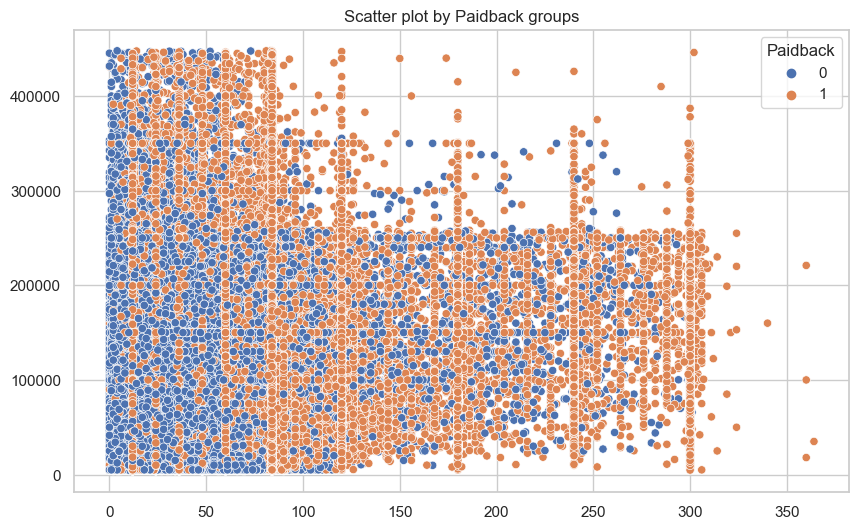

In [287]:
makeplot(df_sba['Term'].values, df_sba['DisbursementGross'].values , df_sba['PaidBack'].values)

In [288]:
df_sba

State  NAICS  Term  NewExist  UrbanRural  RevLineCr  LowDoc  \
12        NC     44   162         1           1          0       0   
24        AR     72   126         0           1          0       0   
28        CA     61    83         1           1          1       0   
30        FL     23    84         0           1          1       0   
32        LA     53    60         0           1          0       0   
...      ...    ...   ...       ...         ...        ...     ...   
863821    CO     61    84         0           0          1       0   
863826    AZ     81    29         1           1          0       0   
863834    AZ     51    84         0           1          1       0   
865073    MT     32   107         0           0          0       0   
867585    NM     45    84         0           1          0       0   

        DisbursementGross  SBA_Appv  PaidBack  
12                 253400    190050         1  
24                 137300    116705         1  
28                 438541     50000         1  
30                  51440     17500         1  
32                  50000     42500         1  
...                   ...       ...       ...  
863821              30000     15000         1  
863826             170000    127500         0  
863834              15635      5000         1  
865073             170000    127500         0  
867585              57000     45600         1  

[428075 rows x 10 columns]

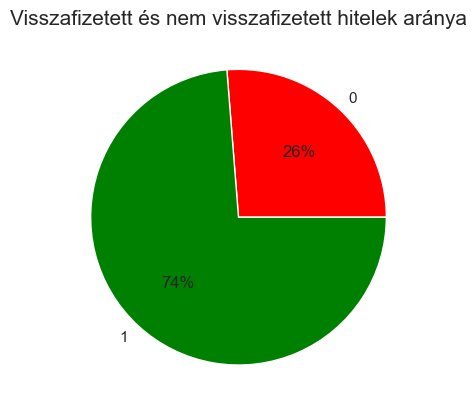

In [289]:
df_sba.groupby('PaidBack').size().plot(kind='pie', autopct='%1.f%%', colors=['red','green'])
plt.title('Visszafizetett és nem visszafizetett hitelek aránya',fontsize=15)
plt.show()

In [290]:
print(len(df_sba[df_sba.PaidBack==0]))
print(len(df_sba[df_sba.PaidBack==1]))

112386
315689


In [291]:
df_paidback_1 = df_sba[df_sba.PaidBack == 1]
df_paidback_1_sample = df_paidback_1.sample(n=len(df_sba[df_sba.PaidBack==0]), random_state=42)
df_paidback_0 = df_sba[df_sba.PaidBack == 0]
df_sba = pd.concat([df_paidback_0, df_paidback_1_sample])
print(df_sba['PaidBack'].value_counts())

0    112386
1    112386
Name: PaidBack, dtype: int64


### Standardizálás

In [292]:
numeric_feature_names = ['Term','DisbursementGross','SBA_Appv']
categoricial_feature_names = ['State','NAICS', 'NewExist','UrbanRural']

df_standardized = df_sba.copy()

ss = StandardScaler()
ss.fit(df_standardized[numeric_feature_names])
df_standardized[numeric_feature_names] = ss.transform(df_standardized[numeric_feature_names])
df_standardized = pd.get_dummies(df_standardized, columns=categoricial_feature_names)
categorical_engineered_features = list(set(df_standardized.columns) - set(numeric_feature_names))
print(categorical_engineered_features)

df_standardized

['NAICS_92', 'State_NY', 'NAICS_72', 'State_KS', 'State_NJ', 'State_VT', 'State_TX', 'RevLineCr', 'NAICS_33', 'State_WA', 'State_SD', 'NAICS_48', 'State_FL', 'State_DE', 'State_OR', 'State_AL', 'State_SC', 'NAICS_22', 'NAICS_21', 'NAICS_11', 'State_NH', 'LowDoc', 'UrbanRural_0', 'UrbanRural_1', 'State_NC', 'State_RI', 'NAICS_44', 'State_MN', 'State_ID', 'State_MS', 'NAICS_71', 'NAICS_45', 'State_IA', 'State_NE', 'State_IN', 'State_MI', 'State_TN', 'State_WI', 'State_DC', 'NAICS_61', 'NAICS_81', 'NewExist_1', 'State_AZ', 'State_OK', 'State_VA', 'State_WV', 'NAICS_62', 'State_AK', 'State_UT', 'NAICS_55', 'State_ME', 'State_OH', 'NAICS_56', 'State_CO', 'State_PA', 'NAICS_31', 'State_HI', 'State_NV', 'State_MO', 'State_WY', 'NAICS_51', 'State_CA', 'NAICS_32', 'NAICS_53', 'State_AR', 'State_ND', 'NAICS_42', 'NewExist_0', 'State_MD', 'State_GA', 'NAICS_49', 'NAICS_23', 'State_LA', 'PaidBack', 'State_CT', 'State_MT', 'State_MA', 'State_KY', 'NAICS_52', 'State_NM', 'NAICS_54', 'State_IL']


Term  RevLineCr  LowDoc  DisbursementGross  SBA_Appv  PaidBack  \
67     -0.929052          1       0          -0.244981 -0.710663         0   
83     -1.413176          0       0          -0.718173 -0.390052         0   
89     -0.283553          1       0          -0.020103 -0.596607         0   
202    -0.905998          1       0           0.183301 -0.368495         0   
208    -0.583249          0       0          -0.055222  0.496050         0   
...          ...        ...     ...                ...       ...       ...   
427991 -0.145232          1       0          -0.546190 -0.482551         1   
115640  0.408053          1       0          -0.312229 -0.710663         1   
804014  0.408053          0       0          -1.051597 -0.841828         1   
536595  0.408053          0       0          -0.546190 -0.163194         1   
21660   0.408053          0       0          -0.979439 -0.824719         1   

        State_AK  State_AL  State_AR  State_AZ  State_CA  State_CO  State_CT  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0   
89             0         0         0         0         0         1         0   
202            0         0         0         0         0         0         0   
208            0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
427991         0         0         0         0         1         0         0   
115640         0         0         0         0         0         0         0   
804014         0         0         0         0         1         0         0   
536595         0         0         0         0         0         0         0   
21660          0         0         0         0         0         0         0   

        State_DC  State_DE  State_FL  State_GA  State_HI  State_IA  State_ID  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0   
89             0         0         0         0         0         0         0   
202            0         0         0         0         0         0         0   
208            0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
427991         0         0         0         0         0         0         0   
115640         0         0         0         0         0         0         0   
804014         0         0         0         0         0         0         0   
536595         0         0         0         0         0         0         0   
21660          0         0         0         0         0         0         0   

        State_IL  State_IN  State_KS  State_KY  State_LA  State_MA  State_MD  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0   
89             0         0         0         0         0         0         0   
202            0         0         0         0         0         0         0   
208            0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
427991         0         0         0         0         0         0         0   
115640         0         0         0         0         0         0         0   
804014         0         0         0         0         0         0         0   
536595         0         0         0         0         0         0         0   
21660          0         0         0         0         0         0         0   

        State_ME  State_MI  State_MN  State_MO  State_MS  State_MT  State_NC  \
67             0         0         0         0         0         0         0   
83             0         0      

### Normalizálás

In [293]:
df_normalized= df_sba.copy()
normalizer = MinMaxScaler()

df_normalized[numeric_feature_names] = normalizer.fit_transform(df_normalized[numeric_feature_names])
df_normalized = pd.get_dummies(df_normalized, columns=categoricial_feature_names)
categorical_engineered_features = list(set(df_normalized.columns) - set(numeric_feature_names))
print(categorical_engineered_features)
df_normalized

['NAICS_92', 'State_NY', 'NAICS_72', 'State_KS', 'State_NJ', 'State_VT', 'State_TX', 'RevLineCr', 'NAICS_33', 'State_WA', 'State_SD', 'NAICS_48', 'State_FL', 'State_DE', 'State_OR', 'State_AL', 'State_SC', 'NAICS_22', 'NAICS_21', 'NAICS_11', 'State_NH', 'LowDoc', 'UrbanRural_0', 'UrbanRural_1', 'State_NC', 'State_RI', 'NAICS_44', 'State_MN', 'State_ID', 'State_MS', 'NAICS_71', 'NAICS_45', 'State_IA', 'State_NE', 'State_IN', 'State_MI', 'State_TN', 'State_WI', 'State_DC', 'NAICS_61', 'NAICS_81', 'NewExist_1', 'State_AZ', 'State_OK', 'State_VA', 'State_WV', 'NAICS_62', 'State_AK', 'State_UT', 'NAICS_55', 'State_ME', 'State_OH', 'NAICS_56', 'State_CO', 'State_PA', 'NAICS_31', 'State_HI', 'State_NV', 'State_MO', 'State_WY', 'NAICS_51', 'State_CA', 'NAICS_32', 'NAICS_53', 'State_AR', 'State_ND', 'NAICS_42', 'NewExist_0', 'State_MD', 'State_GA', 'NAICS_49', 'NAICS_23', 'State_LA', 'PaidBack', 'State_CT', 'State_MT', 'State_MA', 'State_KY', 'NAICS_52', 'State_NM', 'NAICS_54', 'State_IL']


Term  RevLineCr  LowDoc  DisbursementGross  SBA_Appv  PaidBack  \
67      0.071429          1       0           0.128138  0.049165         0   
83      0.013736          0       0           0.054289  0.121905         0   
89      0.148352          1       0           0.163233  0.075042         0   
202     0.074176          1       0           0.194978  0.126795         0   
208     0.112637          0       0           0.157753  0.322940         0   
...          ...        ...     ...                ...       ...       ...   
427991  0.164835          1       0           0.081130  0.100919         1   
115640  0.230769          1       0           0.117643  0.049165         1   
804014  0.230769          0       0           0.002254  0.019407         1   
536595  0.230769          0       0           0.081130  0.173373         1   
21660   0.230769          0       0           0.013515  0.023289         1   

        State_AK  State_AL  State_AR  State_AZ  State_CA  State_CO  State_CT  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0   
89             0         0         0         0         0         1         0   
202            0         0         0         0         0         0         0   
208            0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
427991         0         0         0         0         1         0         0   
115640         0         0         0         0         0         0         0   
804014         0         0         0         0         1         0         0   
536595         0         0         0         0         0         0         0   
21660          0         0         0         0         0         0         0   

        State_DC  State_DE  State_FL  State_GA  State_HI  State_IA  State_ID  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0   
89             0         0         0         0         0         0         0   
202            0         0         0         0         0         0         0   
208            0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
427991         0         0         0         0         0         0         0   
115640         0         0         0         0         0         0         0   
804014         0         0         0         0         0         0         0   
536595         0         0         0         0         0         0         0   
21660          0         0         0         0         0         0         0   

        State_IL  State_IN  State_KS  State_KY  State_LA  State_MA  State_MD  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0   
89             0         0         0         0         0         0         0   
202            0         0         0         0         0         0         0   
208            0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
427991         0         0         0         0         0         0         0   
115640         0         0         0         0         0         0         0   
804014         0         0         0         0         0         0         0   
536595         0         0         0         0         0         0         0   
21660          0         0         0         0         0         0         0   

        State_ME  State_MI  State_MN  State_MO  State_MS  State_MT  State_NC  \
67             0         0         0         0         0         0         0   
83             0         0      

### Skálázatlan adatok átalakítása

In [294]:
df_sba_dummies = pd.get_dummies(df_sba, columns=categoricial_feature_names)
categorical_engineered_features = list(set(df_sba_dummies.columns) - set(numeric_feature_names))
print(categorical_engineered_features)
df_sba_dummies

['NAICS_92', 'State_NY', 'NAICS_72', 'State_KS', 'State_NJ', 'State_VT', 'State_TX', 'RevLineCr', 'NAICS_33', 'State_WA', 'State_SD', 'NAICS_48', 'State_FL', 'State_DE', 'State_OR', 'State_AL', 'State_SC', 'NAICS_22', 'NAICS_21', 'NAICS_11', 'State_NH', 'LowDoc', 'UrbanRural_0', 'UrbanRural_1', 'State_NC', 'State_RI', 'NAICS_44', 'State_MN', 'State_ID', 'State_MS', 'NAICS_71', 'NAICS_45', 'State_IA', 'State_NE', 'State_IN', 'State_MI', 'State_TN', 'State_WI', 'State_DC', 'NAICS_61', 'NAICS_81', 'NewExist_1', 'State_AZ', 'State_OK', 'State_VA', 'State_WV', 'NAICS_62', 'State_AK', 'State_UT', 'NAICS_55', 'State_ME', 'State_OH', 'NAICS_56', 'State_CO', 'State_PA', 'NAICS_31', 'State_HI', 'State_NV', 'State_MO', 'State_WY', 'NAICS_51', 'State_CA', 'NAICS_32', 'NAICS_53', 'State_AR', 'State_ND', 'NAICS_42', 'NewExist_0', 'State_MD', 'State_GA', 'NAICS_49', 'NAICS_23', 'State_LA', 'PaidBack', 'State_CT', 'State_MT', 'State_MA', 'State_KY', 'NAICS_52', 'State_NM', 'NAICS_54', 'State_IL']


Term  RevLineCr  LowDoc  DisbursementGross  SBA_Appv  PaidBack  \
67        26          1       0              60859     10000         0   
83         5          0       0              28090     24055         0   
89        54          1       0              76432     15000         0   
202       27          1       0              90518     25000         0   
208       41          0       0              74000     62900         0   
...      ...        ...     ...                ...       ...       ...   
427991    60          1       0              40000     20000         1   
115640    84          1       0              56202     10000         1   
804014    84          0       0               5000      4250         1   
536595    84          0       0              40000     34000         1   
21660     84          0       0               9997      5000         1   

        State_AK  State_AL  State_AR  State_AZ  State_CA  State_CO  State_CT  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0   
89             0         0         0         0         0         1         0   
202            0         0         0         0         0         0         0   
208            0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
427991         0         0         0         0         1         0         0   
115640         0         0         0         0         0         0         0   
804014         0         0         0         0         1         0         0   
536595         0         0         0         0         0         0         0   
21660          0         0         0         0         0         0         0   

        State_DC  State_DE  State_FL  State_GA  State_HI  State_IA  State_ID  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0   
89             0         0         0         0         0         0         0   
202            0         0         0         0         0         0         0   
208            0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
427991         0         0         0         0         0         0         0   
115640         0         0         0         0         0         0         0   
804014         0         0         0         0         0         0         0   
536595         0         0         0         0         0         0         0   
21660          0         0         0         0         0         0         0   

        State_IL  State_IN  State_KS  State_KY  State_LA  State_MA  State_MD  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0   
89             0         0         0         0         0         0         0   
202            0         0         0         0         0         0         0   
208            0         0         0         0         0         0         0   
...          ...       ...       ...       ...       ...       ...       ...   
427991         0         0         0         0         0         0         0   
115640         0         0         0         0         0         0         0   
804014         0         0         0         0         0         0         0   
536595         0         0         0         0         0         0         0   
21660          0         0         0         0         0         0         0   

        State_ME  State_MI  State_MN  State_MO  State_MS  State_MT  State_NC  \
67             0         0         0         0         0         0         0   
83             0         0         0         0         0         0         0

### Standardizált adatok szétválasztása tanító és teszt adathalmazra

In [295]:
X_s = df_standardized.drop(columns=['PaidBack'])
y_s = df_standardized['PaidBack']
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=42)
print("Tanító adatok mérete (X):", X_train_s.shape)
print("Teszt adatok mérete (X):", X_test_s.shape)
print("Tanító adatok mérete (y):", y_train_s.shape)
print("Teszt adatok mérete (y):", y_test_s.shape)

Tanító adatok mérete (X): (179817, 84)
Teszt adatok mérete (X): (44955, 84)
Tanító adatok mérete (y): (179817,)
Teszt adatok mérete (y): (44955,)


### Normalizált adatok szétválasztása tanító és teszt adathalmazra

In [296]:
X_n = df_normalized.drop(columns=['PaidBack'])
y_n = df_normalized['PaidBack']
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.2, random_state=42)
print("Tanító adatok mérete (X):", X_train_n.shape)
print("Teszt adatok mérete (X):", X_test_n.shape)
print("Tanító adatok mérete (y):", y_train_n.shape)
print("Teszt adatok mérete (y):", y_test_n.shape)

Tanító adatok mérete (X): (179817, 84)
Teszt adatok mérete (X): (44955, 84)
Tanító adatok mérete (y): (179817,)
Teszt adatok mérete (y): (44955,)


### Skálázatlan adatok szétválasztása tanító és teszt adatokra

In [297]:
X_e = df_sba_dummies.drop(columns=['PaidBack'])
y_e = df_sba_dummies['PaidBack']
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.2, random_state=42)
print("Tanító adatok mérete (X):", X_train_e.shape)
print("Teszt adatok mérete (X):", X_test_e.shape)
print("Tanító adatok mérete (y):", y_train_e.shape)
print("Teszt adatok mérete (y):", y_test_e.shape)

Tanító adatok mérete (X): (179817, 84)
Teszt adatok mérete (X): (44955, 84)
Tanító adatok mérete (y): (179817,)
Teszt adatok mérete (y): (44955,)


## Logisztikus regresszor modell

In [298]:
start_time_spec=time.time()
lr_s = LogisticRegression(max_iter=1000)
model_s = lr_s.fit(X_train_s, y_train_s)
end_time_spec=time.time()
training_time_lr_s=end_time_spec-start_time_spec
start_time_spec=time.time()
lr_n = LogisticRegression(max_iter=1000)
model_n = lr_n.fit(X_train_n, y_train_n)
end_time_spec=time.time()
training_time_lr_n=end_time_spec-start_time_spec
start_time_spec=time.time()
lr_e = LogisticRegression(max_iter=1000)
model_e = lr_e.fit(X_train_e, y_train_e)
end_time_spec=time.time()
training_time_lr_e=end_time_spec-start_time_spec

training_time_lr = training_time_lr_e+training_time_lr_s+training_time_lr_n
print(f"A tanítási idő: {training_time_lr:.2f} másodperc")

A tanítási idő: 15.01 másodperc


In [299]:
y_pred_s = lr_s.predict(X_test_s)
y_pred_n = lr_n.predict(X_test_n)
y_pred_e = lr_e.predict(X_test_e)
cm_s_lr = confusion_matrix(y_test_s, y_pred_s)
cm_n_lr = confusion_matrix(y_test_n, y_pred_n)
cm_e_lr = confusion_matrix(y_test_e, y_pred_e)
accuracy_s_lr = accuracy_score(y_test_s, y_pred_s)
accuracy_n_lr = accuracy_score(y_test_n, y_pred_n)
accuracy_e_lr = accuracy_score(y_test_e, y_pred_e)
precision_s_lr = precision_score(y_test_s, y_pred_s, average='weighted')
precision_n_lr = precision_score(y_test_n, y_pred_n, average='weighted')
precision_e_lr = precision_score(y_test_e, y_pred_e, average='weighted')
recall_s_lr = recall_score(y_test_s, y_pred_s, average='weighted')
recall_n_lr = recall_score(y_test_n, y_pred_n, average='weighted')
recall_e_lr = recall_score(y_test_e, y_pred_e, average='weighted')
f1_s_lr = f1_score(y_test_s, y_pred_s, average='weighted')
f1_n_lr = f1_score(y_test_n, y_pred_n, average='weighted')
f1_e_lr = f1_score(y_test_e, y_pred_e, average='weighted')
mse_s_lr = mean_squared_error(y_test_s, y_pred_s)
mse_n_lr = mean_squared_error(y_test_n, y_pred_n)
mse_e_lr = mean_squared_error(y_test_e, y_pred_e)

y_proba_s = lr_s.predict_proba(X_test_s)[:, 1]
y_proba_n = lr_n.predict_proba(X_test_n)[:, 1]
y_proba_e = lr_e.predict_proba(X_test_e)[:, 1]
roc_auc_s_lr = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_lr = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_lr = roc_auc_score(y_test_e, y_proba_e)

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s))
print('Normalizált adatok')
print(classification_report(y_test_n, y_pred_n))

Skálázatlan adatok
              precision    recall  f1-score   support

           0       0.75      0.30      0.43     22361
           1       0.56      0.90      0.69     22594

    accuracy                           0.60     44955
   macro avg       0.65      0.60      0.56     44955
weighted avg       0.65      0.60      0.56     44955

Standardizált adatok
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     22361
           1       0.79      0.79      0.79     22594

    accuracy                           0.79     44955
   macro avg       0.79      0.79      0.79     44955
weighted avg       0.79      0.79      0.79     44955

Normalizált adatok
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     22361
           1       0.79      0.79      0.79     22594

    accuracy                           0.79     44955
   macro avg       0.79      0.79      0.79     44955
weighted avg   

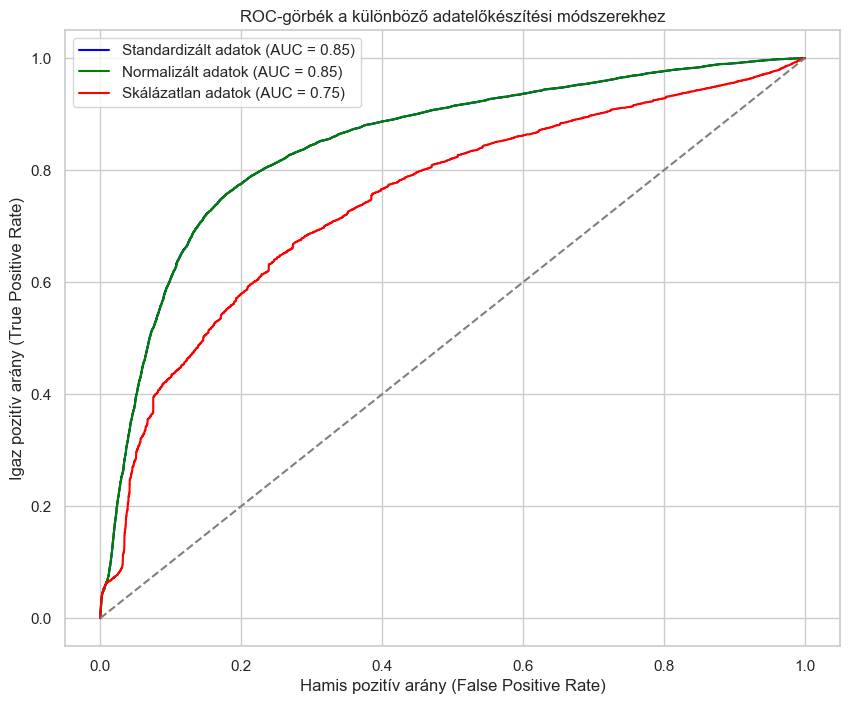

    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.600489              0.787699            0.787521
1  Precision            0.654397              0.787698            0.787520
2     Recall            0.600489              0.787699            0.787521
3   F1 Score            0.560770              0.787697            0.787519
4        MSE            0.399511              0.212301            0.212479
5        AUC            0.746518              0.846856            0.846815


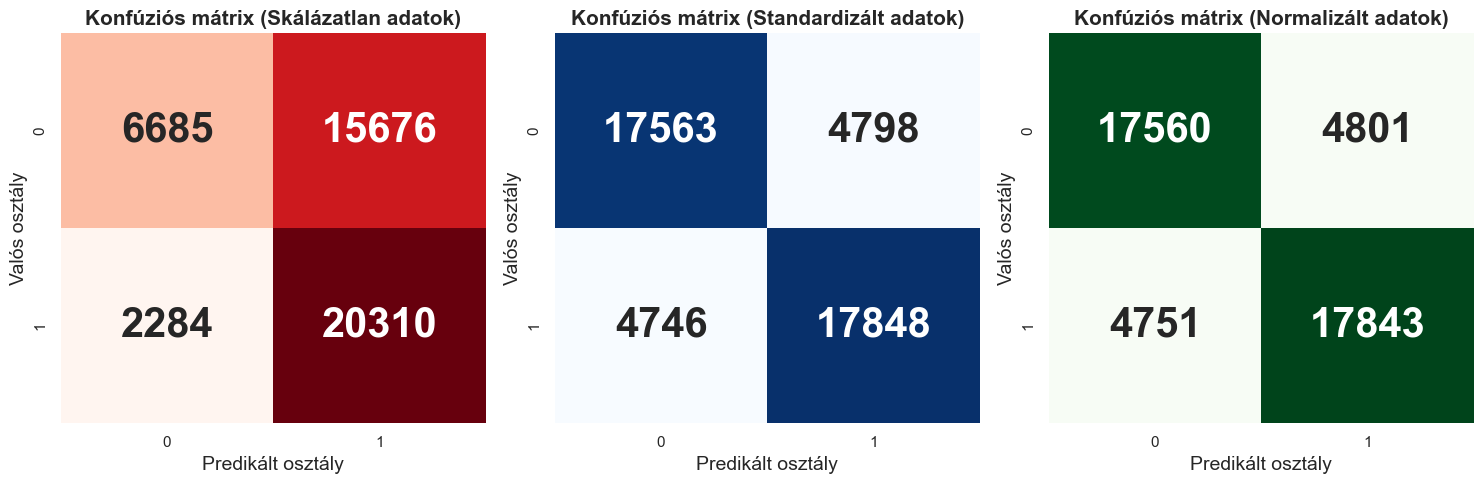

In [300]:
results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_lr, precision_e_lr, recall_e_lr, f1_e_lr, mse_e_lr, roc_auc_e_lr],
    "Standardizált adatok": [accuracy_s_lr, precision_s_lr, recall_s_lr, f1_s_lr, mse_s_lr, roc_auc_s_lr],
    "Normalizált adatok": [accuracy_n_lr, precision_n_lr, recall_n_lr, f1_n_lr, mse_n_lr, roc_auc_n_lr]  
}

fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_lr:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_lr:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_lr:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()


results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_lr, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_lr, annot=True, cmap='Blues', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_lr, annot=True, cmap='Greens', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

## Döntési fa modell

In [301]:
start_time_spec=time.time()
decision_tree_s = DecisionTreeClassifier()
decision_tree_s.fit(X_train_s, y_train_s)
end_time_spec=time.time()
training_time_df_s=end_time_spec-start_time_spec

start_time_spec=time.time()
decision_tree_n = DecisionTreeClassifier()
decision_tree_n.fit(X_train_n, y_train_n)
end_time_spec=time.time()
training_time_df_n=end_time_spec-start_time_spec

start_time_spec=time.time()
decision_tree_e = DecisionTreeClassifier()
decision_tree_e.fit(X_train_e, y_train_e)
end_time_spec=time.time()
training_time_df_e=end_time_spec-start_time_spec

training_time_df = training_time_df_e+training_time_df_s+training_time_df_n
print(f"A tanítási idő: {training_time_df:.2f} másodperc\n")

y_pred_s = decision_tree_s.predict(X_test_s)
y_pred_n = decision_tree_n.predict(X_test_n)
y_pred_e = decision_tree_e.predict(X_test_e)

accuracy_s_df = accuracy_score(y_test_s, y_pred_s)
accuracy_n_df = accuracy_score(y_test_n, y_pred_n)
accuracy_e_df = accuracy_score(y_test_e, y_pred_e)

precision_s_df = precision_score(y_test_s, y_pred_s, average='weighted')
precision_n_df = precision_score(y_test_n, y_pred_n, average='weighted')
precision_e_df = precision_score(y_test_e, y_pred_e, average='weighted')

recall_s_df = recall_score(y_test_s, y_pred_s, average='weighted')
recall_n_df = recall_score(y_test_n, y_pred_n, average='weighted')
recall_e_df = recall_score(y_test_e, y_pred_e, average='weighted')

f1_s_df = f1_score(y_test_s, y_pred_s, average='weighted')
f1_n_df = f1_score(y_test_n, y_pred_n, average='weighted')
f1_e_df = f1_score(y_test_e, y_pred_e, average='weighted')

mse_s_df = mean_squared_error(y_test_s, y_pred_s)
mse_n_df = mean_squared_error(y_test_n, y_pred_n)
mse_e_df = mean_squared_error(y_test_e, y_pred_e)

y_proba_s = decision_tree_s.predict_proba(X_test_s)[:, 1]
y_proba_n = decision_tree_n.predict_proba(X_test_n)[:, 1]
y_proba_e = decision_tree_e.predict_proba(X_test_e)[:, 1]
roc_auc_s_df = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_df = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_df = roc_auc_score(y_test_e, y_proba_e)

print("Skálázatlan adatok")
print(classification_report(y_test_e, y_pred_e))
print("Standardizált adatok")
print(classification_report(y_test_s, y_pred_s))
print("Normalizált adatok")
print(classification_report(y_test_n, y_pred_n))

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_df, precision_e_df, recall_e_df, f1_e_df, mse_e_df, roc_auc_e_df],
    "Standardizált adatok": [accuracy_s_df, precision_s_df, recall_s_df, f1_s_df, mse_s_df, roc_auc_s_df],
    "Normalizált adatok": [accuracy_n_df, precision_n_df, recall_n_df, f1_n_df, mse_n_df, roc_auc_n_df]   
}

results_df = pd.DataFrame(results)
print(results_df)

A tanítási idő: 12.71 másodperc

Skálázatlan adatok
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     22361
           1       0.90      0.89      0.89     22594

    accuracy                           0.89     44955
   macro avg       0.89      0.89      0.89     44955
weighted avg       0.89      0.89      0.89     44955

Standardizált adatok
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     22361
           1       0.90      0.89      0.89     22594

    accuracy                           0.89     44955
   macro avg       0.89      0.89      0.89     44955
weighted avg       0.89      0.89      0.89     44955

Normalizált adatok
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     22361
           1       0.90      0.89      0.90     22594

    accuracy                           0.90     44955
   macro avg       0.90      0.90   

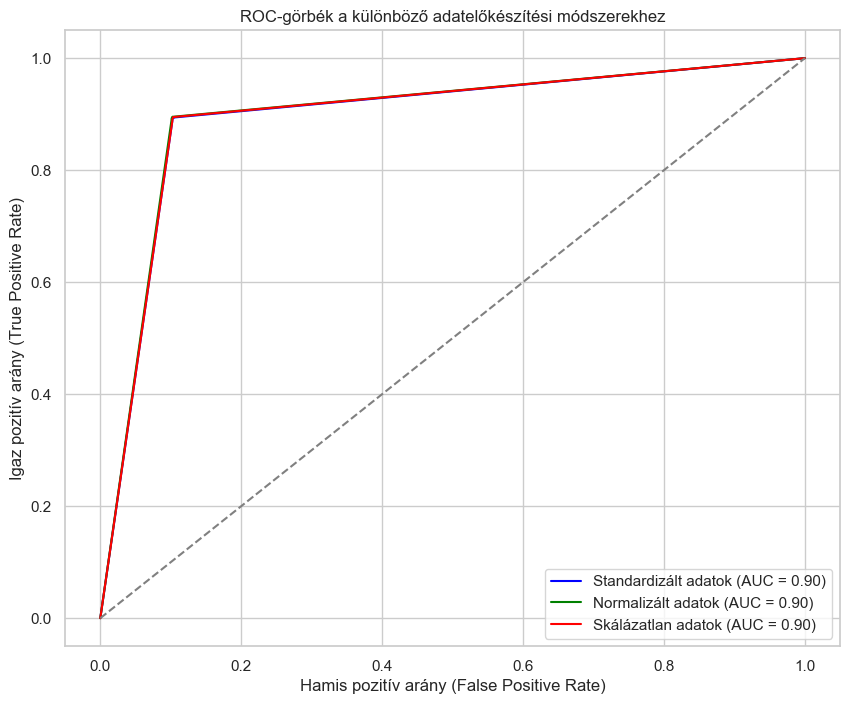

In [302]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_df:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_df:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_df:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()

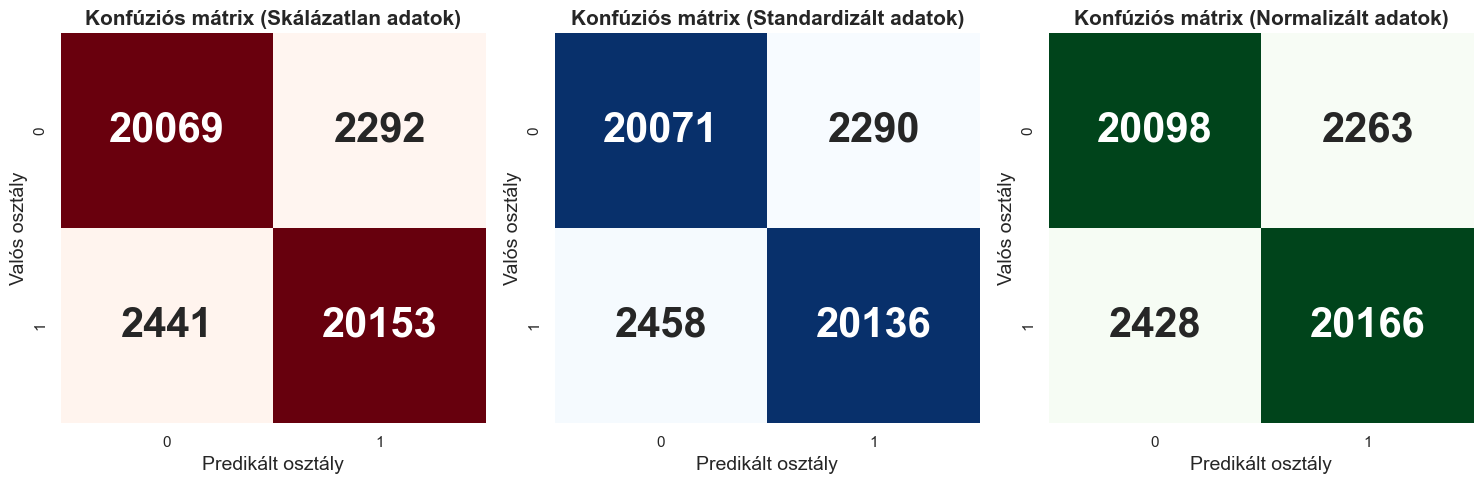

In [303]:
cm_s_df = confusion_matrix(y_test_s, y_pred_s)
cm_n_df = confusion_matrix(y_test_n, y_pred_n)
cm_e_df = confusion_matrix(y_test_e, y_pred_e)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_df, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_df, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_df, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

## Regularizált döntési fa

In [304]:
param_space = {
    'max_depth': Categorical([None, 5, 10, 15]),
    'min_samples_split': Integer(2, 5),
    'min_samples_leaf': Integer(1, 5),
    'ccp_alpha': Real(0.0, 0.01)
}

opt = BayesSearchCV(
    estimator=DecisionTreeClassifier(),
    search_spaces=param_space,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

start_time_spec=time.time()
opt.fit(X_train_s, y_train_s)
end_time_spec=time.time()
training_time_rdf_s=end_time_spec-start_time_spec

best_params = opt.best_params_
print("Legjobb paraméterek Standardizált adatokon:", best_params)
best_model_rdf_s = opt.best_estimator_
y_pred_s = best_model_rdf_s.predict(X_test_s)
print("Standardizált adatokon a legjobb modell értékelése:")
print(classification_report(y_test_s, y_pred_s))
accuracy_s_rdf = accuracy_score(y_test_s, y_pred_s)
precision_s_rdf = precision_score(y_test_s, y_pred_s, average='weighted')
recall_s_rdf = recall_score(y_test_s, y_pred_s, average='weighted')
f1_s_rdf = f1_score(y_test_s, y_pred_s, average='weighted')
mse_s_rdf = mean_squared_error(y_test_s, y_pred_s)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
results = pd.DataFrame(opt.cv_results_)
results = results.sort_values(by='rank_test_score')
print("Paraméterkombinációk és rangsorolásuk táblázata Standardizált adatokon:")
print(results[['params', 'mean_test_score', 'rank_test_score']])

start_time_spec=time.time()
opt.fit(X_train_n, y_train_n)
end_time_spec=time.time()
training_time_rdf_n=end_time_spec-start_time_spec

best_params = opt.best_params_
print("Legjobb paraméterek Normalizált adatokon:", best_params)
best_model_rdf_n = opt.best_estimator_
y_pred_n = best_model_rdf_n.predict(X_test_n)
print("Normalizált adatokon a legjobb modell értékelése:")
print(classification_report(y_test_n, y_pred_n))
accuracy_n_rdf = accuracy_score(y_test_n, y_pred_n)
precision_n_rdf = precision_score(y_test_n, y_pred_n, average='weighted')
recall_n_rdf = recall_score(y_test_n, y_pred_n, average='weighted')
f1_n_rdf = f1_score(y_test_n, y_pred_n, average='weighted')
mse_n_rdf = mean_squared_error(y_test_n, y_pred_n)
results = pd.DataFrame(opt.cv_results_)
results = results.sort_values(by='rank_test_score')
print("Paraméterkombinációk és rangsorolásuk táblázata Normalizált adatokon:")
print(results[['params', 'mean_test_score', 'rank_test_score']])

start_time_spec=time.time()
opt.fit(X_train_e, y_train_e)
end_time_spec=time.time()
training_time_rdf_e=end_time_spec-start_time_spec

best_params = opt.best_params_
print("Legjobb paraméterek Skálázatlan adatokon:", best_params)
best_model_rdf_e = opt.best_estimator_
y_pred_e = best_model_rdf_e.predict(X_test_e)
print("Skálázatlan adatokon a legjobb modell értékelése:")
print(classification_report(y_test_e, y_pred_e))
accuracy_e_rdf = accuracy_score(y_test_e, y_pred_e)
precision_e_rdf = precision_score(y_test_e, y_pred_e, average='weighted')
recall_e_rdf = recall_score(y_test_e, y_pred_e, average='weighted')
f1_e_rdf = f1_score(y_test_e, y_pred_e, average='weighted')
mse_e_rdf = mean_squared_error(y_test_e, y_pred_e)
results = pd.DataFrame(opt.cv_results_)
results = results.sort_values(by='rank_test_score')
print("Paraméterkombinációk és rangsorolásuk táblázata Skálázatlan adatokon:")
print(results[['params', 'mean_test_score', 'rank_test_score']])

training_time_rdf = training_time_rdf_s+training_time_rdf_n+training_time_rdf_e
print(f"A tanítási idő: {training_time_rdf:.2f} másodperc")


y_proba_s = best_model_rdf_s.predict_proba(X_test_s)[:, 1]
y_proba_n = best_model_rdf_n.predict_proba(X_test_n)[:, 1]
y_proba_e = best_model_rdf_e.predict_proba(X_test_e)[:, 1]
roc_auc_s_rdf = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_rdf = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_rdf = roc_auc_score(y_test_e, y_proba_e)

Legjobb paraméterek Standardizált adatokon: OrderedDict([('ccp_alpha', 3.0462408453571212e-05), ('max_depth', None), ('min_samples_leaf', 4), ('min_samples_split', 2)])
Standardizált adatokon a legjobb modell értékelése:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     22361
           1       0.93      0.92      0.92     22594

    accuracy                           0.92     44955
   macro avg       0.92      0.92      0.92     44955
weighted avg       0.92      0.92      0.92     44955

Paraméterkombinációk és rangsorolásuk táblázata Standardizált adatokon:
                                                                                                     params  \
13  {'ccp_alpha': 3.0462408453571212e-05, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}   
54    {'ccp_alpha': 2.8919594671937837e-05, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3}   
66   {'ccp_alpha': 1.780035437983885e-05, 'max_

In [305]:
results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_rdf, precision_e_rdf, recall_e_rdf, f1_e_rdf, mse_e_rdf, roc_auc_e_rdf],
    "Standardizált adatok": [accuracy_s_rdf, precision_s_rdf, recall_s_rdf, f1_s_rdf, mse_s_rdf, roc_auc_s_rdf],
    "Normalizált adatok": [accuracy_n_rdf, precision_n_rdf, recall_n_rdf, f1_n_rdf, mse_n_rdf, roc_auc_n_rdf]   
}
results_df = pd.DataFrame(results)
print(results_df)

    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.923568              0.923835            0.923790
1  Precision            0.923623              0.923983            0.923967
2     Recall            0.923568              0.923835            0.923790
3   F1 Score            0.923568              0.923832            0.923787
4        MSE            0.076432              0.076165            0.076210
5        AUC            0.965659              0.965682            0.965152


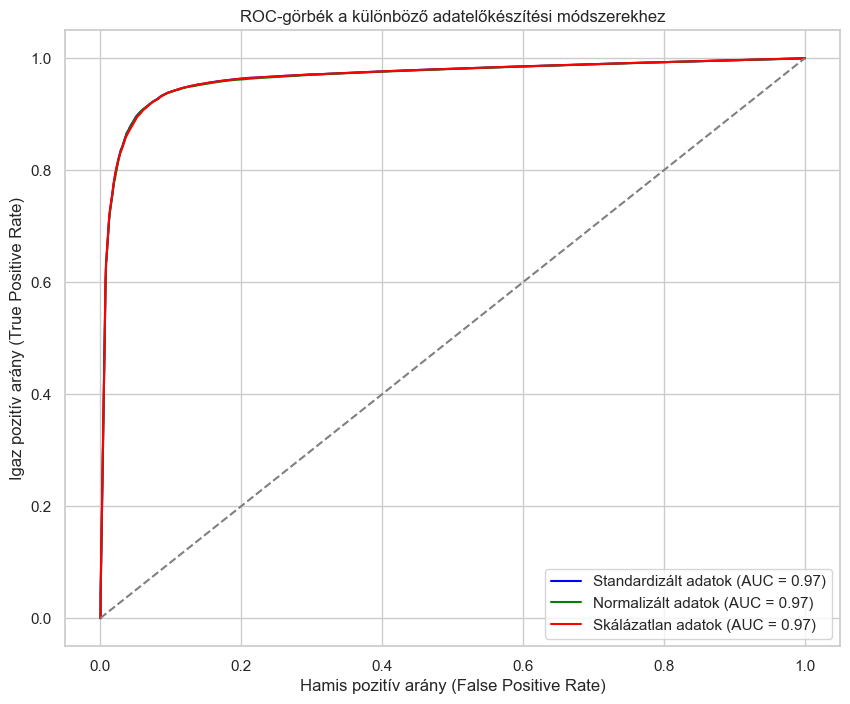

In [306]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_rdf:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_rdf:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_rdf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()

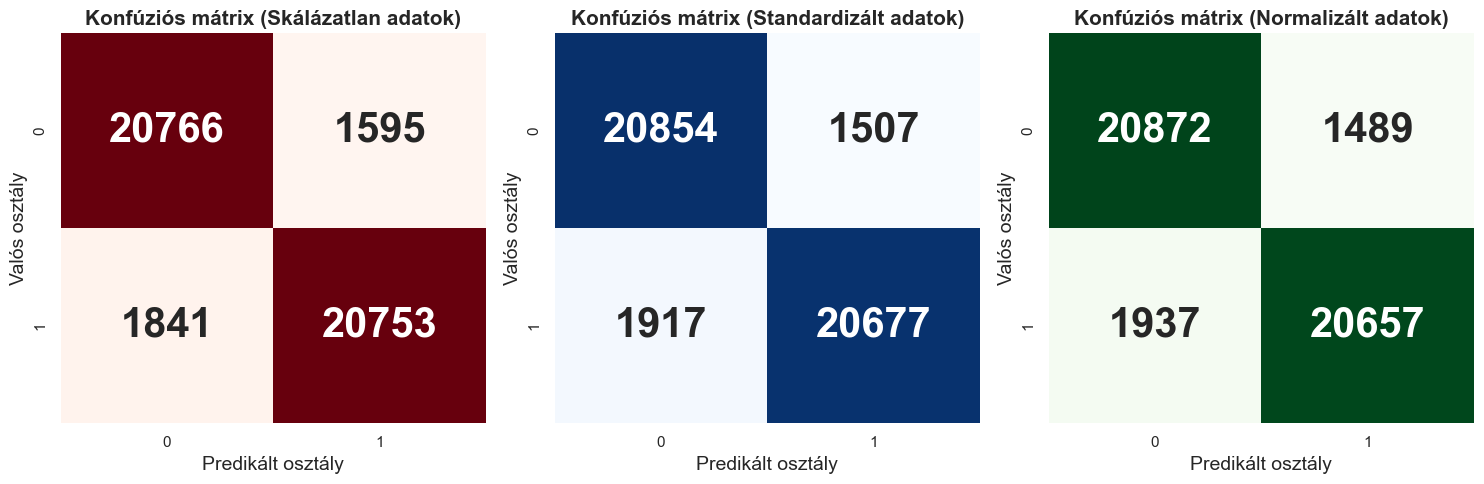

In [307]:
cm_s_rdf = confusion_matrix(y_test_s, y_pred_s)
cm_n_rdf = confusion_matrix(y_test_n, y_pred_n)
cm_e_rdf = confusion_matrix(y_test_e, y_pred_e)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_rdf, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g',cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_rdf, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_rdf, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

## Gradiens turbózás K-fold keresztvalidációval és korai leállással 

In [343]:
params_s = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'num_leaves': 31, 
    'max_bin': 255,
    'learning_rate': 0.1,
    'metric': ['binary_logloss', 'auc'],
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 4,
    'lambda_l1': 3.0462408453571212e-05,
    'min_samples_split': 2
}

params_n = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'num_leaves': 31, 
    'max_bin': 255,
    'learning_rate': 0.1,
    'metric': ['binary_logloss', 'auc'],
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 4,
    'lambda_l1': 3.3752123062790194e-05,
    'min_samples_split': 2
}

params_e = {
    'boosting_type': 'gbdt',
    'objective': 'binary', 
    'num_leaves': 31, 
    'max_bin': 255,
    'learning_rate': 0.1,
    'metric': ['binary_logloss', 'auc'], 
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 5,
    'lambda_l1': 3.0039052445248978e-05,
    'min_samples_split': 5,
    'max_depth': 15
}

In [344]:
def experiment(objective, label_type, x_train, x_test, y_train, y_test, params, i, fajl):
    lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
    lgb_test = lgb.Dataset(x_test, y_test, free_raw_data=False)    
    params['objective'] = objective
    fajlnev = f"{fajl}_gbmodel.txt"
    if i == 0:
        gbm = lgb.train(
            params=params, 
            train_set=lgb_train, 
            valid_sets=[lgb_train, lgb_test],
            num_boost_round=10
        ) 
        gbm.save_model(fajlnev)
    else:
        gbmprev = lgb.Booster(model_file=fajlnev) 
        gbm = lgb.train(
            params=params,
            train_set=lgb_train,
            valid_sets=[lgb_train, lgb_test],
            num_boost_round=10,
            init_model=gbmprev
        ) 
        gbm.save_model(fajlnev) 
      
    y_fitted = pd.Series(gbm.predict(x_test, num_iteration=gbm.best_iteration))
    y_pred = pd.DataFrame({'y_pred': y_fitted})
    y_true = pd.DataFrame({'y': y_test})
    return pd.concat([y_true.reset_index(drop=True), y_pred], axis=1)

In [345]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
primary_target = 'binary'
tree_num = 100

def run_experiment(X, y, params, fajl):
    A = []
    accuracy = []
    previous_score = 0
    early_stopping_rounds = 5
    no_improvement = 0
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{num_folds}")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        for k in range(tree_num):
            if no_improvement < early_stopping_rounds:
                result = experiment(primary_target, 'binary', X_train, X_test, y_train, y_test, params, k, fajl)
                A.append(result)
                current_score = accuracy_score(result['y'], result['y_pred'].round())
                accuracy.append({
                    'current': current_score,
                    'previous': previous_score,
                    'no_improvement': no_improvement,
                    'early_stopping_rounds': early_stopping_rounds,
                    'no_improvement_s < early_stopping_rounds': no_improvement < early_stopping_rounds
                })
                if current_score > previous_score:
                    previous_score = current_score
                    no_improvement = 0
                else:
                    no_improvement += 1
            else:
                print("Korai leállás")
                break

    return A, accuracy

start_time_spec=time.time()
A_s, accuracy_s = run_experiment(X_s, y_s, params_s, "s")
end_time_spec=time.time()
training_time_gt_s=end_time_spec-start_time_spec
start_time_spec=time.time()
A_n, accuracy_n = run_experiment(X_n, y_n, params_n, "n")
end_time_spec=time.time()
training_time_gt_n=end_time_spec-start_time_spec
start_time_spec=time.time()
A_e, accuracy_e = run_experiment(X_e, y_e, params_e, "e")
end_time_spec=time.time()
training_time_gt_e=end_time_spec-start_time_spec
end_time = time.time()
training_time_gt = training_time_gt_e+training_time_gt_s+training_time_gt_n

Fold 1/5
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499352 -> initscore=-0.002592
[LightGBM] [Info] Start training from score -0.002592
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parame

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004636 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown par

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may 

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 916
[LightGBM] [Info] Number of data points in the train set: 179817, number of used features: 84
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may 

[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 89792, number of negative: 90025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 91

In [346]:
print(f"A tanítási idő: {training_time_gt:.2f} másodperc")

A tanítási idő: 176.28 másodperc


Skálázatlan adatok


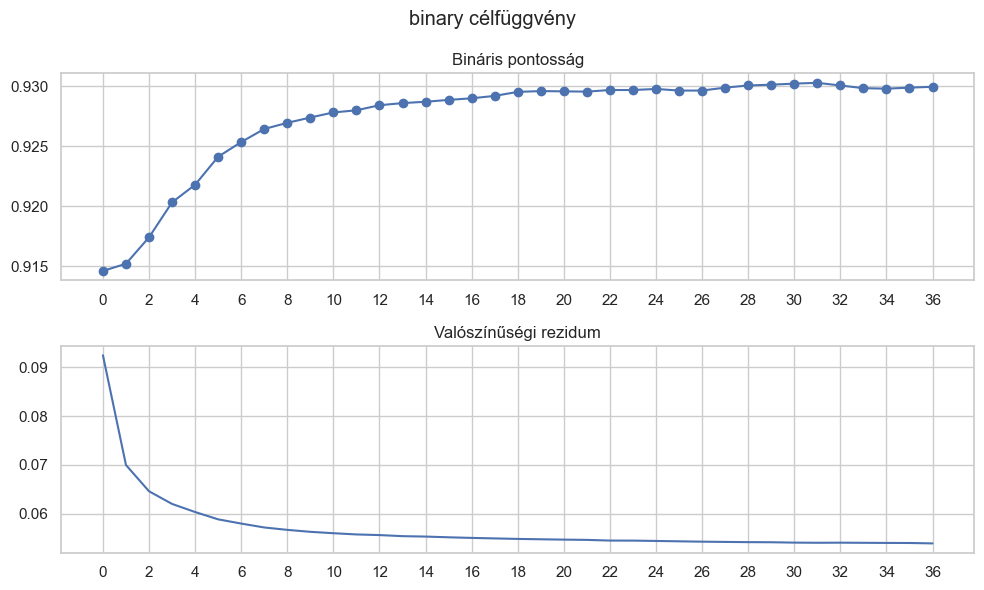

Standardizált adatok


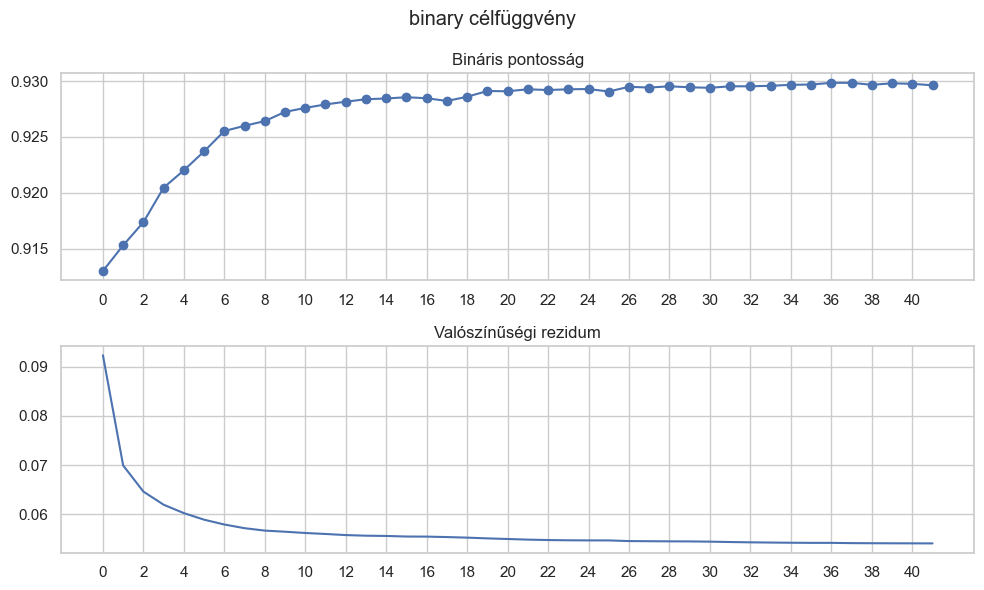

Normalizált adatok


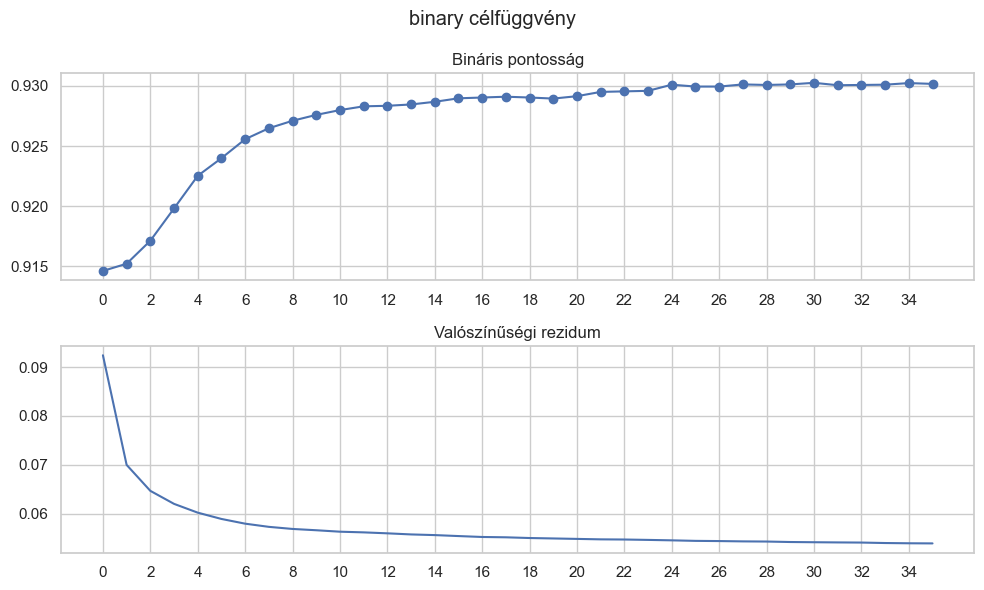

In [347]:
accuracy_binary = lambda D: [accuracy_score(x['y'], x['y_pred'].round()) for x in D]
accuracy_mean = lambda D: [mean_squared_error(x['y'], x['y_pred']) for x in D]

def accplot(accdata, objective):
    fig = plt.figure(figsize=(10,6))
    ax2 = fig.add_subplot(2,1,2)
    ax1 = fig.add_subplot(2,1,1, sharex=ax2) 
    fig.suptitle(objective + ' célfüggvény')
    ax1.plot(accuracy_binary(accdata), '-ob')
    ax1.set_title('Bináris pontosság')
    ax2.plot(accuracy_mean(accdata))
    ax2.set_title('Valószínűségi rezidum')
    ticks = np.arange(0, len(accdata))
    plt.xticks(ticks[::2], ticks[::2])
    plt.tight_layout()
    plt.show()
    
print('Skálázatlan adatok')
accplot(A_e, 'binary')
print('Standardizált adatok')
accplot(A_s, 'binary')
print('Normalizált adatok')
accplot(A_n, 'binary')

In [348]:
print(len(A_e))
print(len(A_s))
print(len(A_n))

37
42
36


In [349]:
y_pred_binary_s = (A_s[-6]['y_pred']>= 0.5).astype(int)
y_pred_binary_n = (A_n[-6]['y_pred']>= 0.5).astype(int)
y_pred_binary_e = (A_e[-6]['y_pred']>= 0.5).astype(int)
y_real_s = A_s[-6]['y']
y_real_n = A_n[-6]['y']
y_real_e = A_e[-6]['y']
y_proba_s = A_s[-6]['y_pred'].values
y_proba_n = A_s[-6]['y_pred'].values
y_proba_e = A_s[-6]['y_pred'].values

accuracy_s_gt = accuracy_score(y_real_s, y_pred_binary_s)
accuracy_n_gt = accuracy_score(y_real_n, y_pred_binary_n)
accuracy_e_gt = accuracy_score(y_real_e, y_pred_binary_e)

precision_s_gt = precision_score(y_real_s, y_pred_binary_s, average='weighted')
precision_n_gt = precision_score(y_real_n,  y_pred_binary_n, average='weighted')
precision_e_gt = precision_score(y_real_e, y_pred_binary_e, average='weighted')

recall_s_gt = recall_score(y_real_s, y_pred_binary_s, average='weighted')
recall_n_gt = recall_score(y_real_n,  y_pred_binary_n, average='weighted')
recall_e_gt = recall_score(y_real_e, y_pred_binary_e, average='weighted')

f1_s_gt = f1_score(y_real_s, y_pred_binary_s, average='weighted')
f1_n_gt = f1_score(y_real_n, y_pred_binary_n, average='weighted')
f1_e_gt = f1_score(y_real_e, y_pred_binary_e, average='weighted')

mse_s_gt = mean_squared_error(y_real_s, y_pred_binary_s)
mse_n_gt = mean_squared_error(y_real_n, y_pred_binary_n)
mse_e_gt = mean_squared_error(y_real_e, y_pred_binary_e)

roc_auc_s_gt = roc_auc_score(y_test_s, y_proba_s)
roc_auc_n_gt = roc_auc_score(y_test_n, y_proba_n)
roc_auc_e_gt = roc_auc_score(y_test_e, y_proba_e)

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "AUC"],
    "Skálázatlan adatok": [accuracy_e_gt, precision_e_gt, recall_e_gt, f1_e_gt, mse_e_gt, roc_auc_e_gt],
    "Standardizált adatok": [accuracy_s_gt, precision_s_gt, recall_s_gt, f1_s_gt, mse_s_gt, roc_auc_s_gt],
    "Normalizált adatok": [accuracy_n_gt, precision_n_gt, recall_n_gt, f1_n_gt, mse_n_gt, roc_auc_n_gt]   
}

results_df = pd.DataFrame(results)
print(results_df)

    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.930286              0.929841            0.930264
1  Precision            0.930351              0.929897            0.930326
2     Recall            0.930286              0.929841            0.930264
3   F1 Score            0.930286              0.929841            0.930263
4        MSE            0.069714              0.070159            0.069736
5        AUC            0.495824              0.495824            0.495824


In [350]:
cm_s_gt = confusion_matrix(y_real_s, y_pred_binary_s)
cm_n_gt = confusion_matrix(y_real_n, y_pred_binary_n)
cm_e_gt = confusion_matrix(y_real_e, y_pred_binary_e)

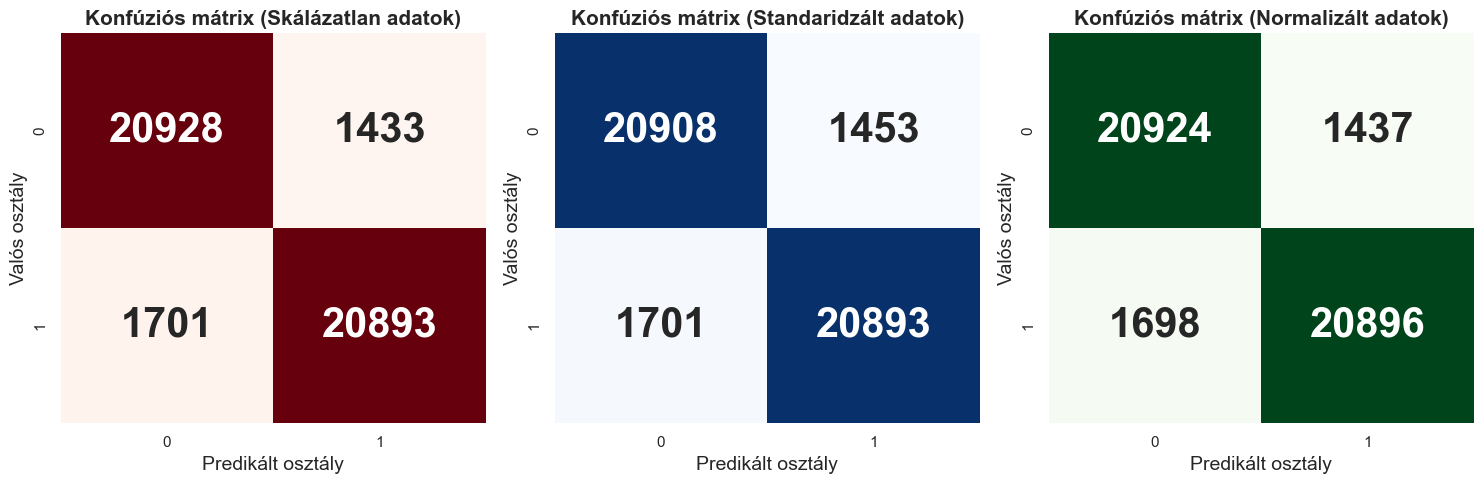

In [351]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_gt, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_gt, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Standaridzált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_gt, annot=True, cmap="Greens", fmt="d", annot_kws={"size": 30, "fontweight": "bold"},cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)',fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály',fontsize=14)
plt.ylabel('Valós osztály',fontsize=14)

plt.tight_layout()
plt.show()

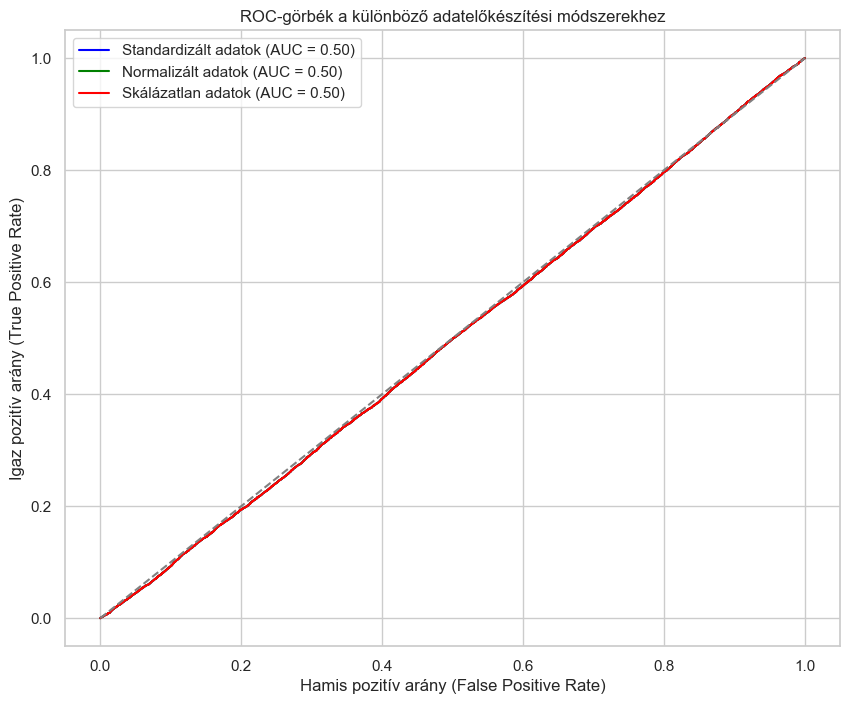

In [352]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_gt:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_gt:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_gt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()

## Neurális háló Keras

In [318]:
def check_and_convert_data(data):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    return data.astype(np.float32)

def create_and_train_model(X_train, y_train, X_test, y_test):
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)
    
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train_cat, epochs=50, batch_size=32, verbose=0)
    
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    return model, y_pred, y_pred_prob 

X_train_s = check_and_convert_data(X_train_s)
X_test_s = check_and_convert_data(X_test_s)
X_train_n = check_and_convert_data(X_train_n)
X_test_n = check_and_convert_data(X_test_n)
X_train_e = check_and_convert_data(X_train_e)
X_test_e = check_and_convert_data(X_test_e)

y_train_s = np.array(y_train_s)
y_test_s = np.array(y_test_s)
y_train_n = np.array(y_train_n)
y_test_n = np.array(y_test_n)
y_train_e = np.array(y_train_e)
y_test_e = np.array(y_test_e)

start_time_spec = time.time()
model_s, y_pred_s_nn, y_proba_s_nn = create_and_train_model(X_train_s, y_train_s, X_test_s, y_test_s)
end_time_spec = time.time()
training_time_nn_s = end_time_spec - start_time_spec

start_time_spec = time.time()
model_n, y_pred_n_nn, y_proba_n_nn = create_and_train_model(X_train_n, y_train_n, X_test_n, y_test_n)
end_time_spec = time.time()
training_time_nn_n = end_time_spec - start_time_spec

start_time_spec = time.time()
model_e, y_pred_e_nn, y_proba_e_nn = create_and_train_model(X_train_e, y_train_e, X_test_e, y_test_e)
end_time_spec = time.time()
training_time_nn_e = end_time_spec - start_time_spec

training_time_nn = training_time_nn_e + training_time_nn_s + training_time_nn_n
print(f"A tanítási idő: {training_time_nn:.2f} másodperc")

accuracy_s_nn = accuracy_score(y_test_s, y_pred_s_nn)
accuracy_n_nn = accuracy_score(y_test_n, y_pred_n_nn)
accuracy_e_nn = accuracy_score(y_test_e, y_pred_e_nn)

precision_s_nn = precision_score(y_test_s, y_pred_s_nn, average='weighted')
precision_n_nn = precision_score(y_test_n, y_pred_n_nn, average='weighted')
precision_e_nn = precision_score(y_test_e, y_pred_e_nn, average='weighted')

recall_s_nn = recall_score(y_test_s, y_pred_s_nn, average='weighted')
recall_n_nn = recall_score(y_test_n, y_pred_n_nn, average='weighted')
recall_e_nn = recall_score(y_test_e, y_pred_e_nn, average='weighted')

f1_s_nn = f1_score(y_test_s, y_pred_s_nn, average='weighted')
f1_n_nn = f1_score(y_test_n, y_pred_n_nn, average='weighted')
f1_e_nn = f1_score(y_test_e, y_pred_e_nn, average='weighted')

mse_s_nn = mean_squared_error(y_test_s, y_pred_s_nn)
mse_n_nn = mean_squared_error(y_test_n, y_pred_n_nn)
mse_e_nn = mean_squared_error(y_test_e, y_pred_e_nn)

y_test_s_cat = to_categorical(y_test_s, num_classes=len(np.unique(y_train_s)))
y_test_n_cat = to_categorical(y_test_n, num_classes=len(np.unique(y_train_n)))
y_test_e_cat = to_categorical(y_test_e, num_classes=len(np.unique(y_train_e)))


roc_auc_s_nn = roc_auc_score(y_test_s_cat, y_proba_s_nn, multi_class='ovr')
roc_auc_n_nn = roc_auc_score(y_test_n_cat, y_proba_n_nn, multi_class='ovr')
roc_auc_e_nn = roc_auc_score(y_test_e_cat, y_proba_e_nn, multi_class='ovr')

results = {
    "Mérőszám": ["Accuracy", "Precision", "Recall", "F1 Score", "MSE", "ROC AUC"],
    "Skálázatlan adatok": [accuracy_e_nn, precision_e_nn, recall_e_nn, f1_e_nn, mse_e_nn, roc_auc_e_nn],
    "Standardizált adatok": [accuracy_s_nn, precision_s_nn, recall_s_nn, f1_s_nn, mse_s_nn, roc_auc_s_nn],
    "Normalizált adatok": [accuracy_n_nn, precision_n_nn, recall_n_nn, f1_n_nn, mse_n_nn, roc_auc_n_nn]   
}

results_df = pd.DataFrame(results)
print(results_df)


1405/1405 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1405/1405 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
A tanítási idő: 911.57 másodperc
    Mérőszám  Skálázatlan adatok  Standardizált adatok  Normalizált adatok
0   Accuracy            0.507241              0.890135            0.863463
1  Precision            0.718959              0.891022            0.866262
2     Recall            0.507241              0.890135            0.863463
3   F1 Score            0.353184              0.890087            0.863238
4        MSE            0.492759              0.109865            0.136537
5    ROC AUC            0.509039              0.951001            0.934400


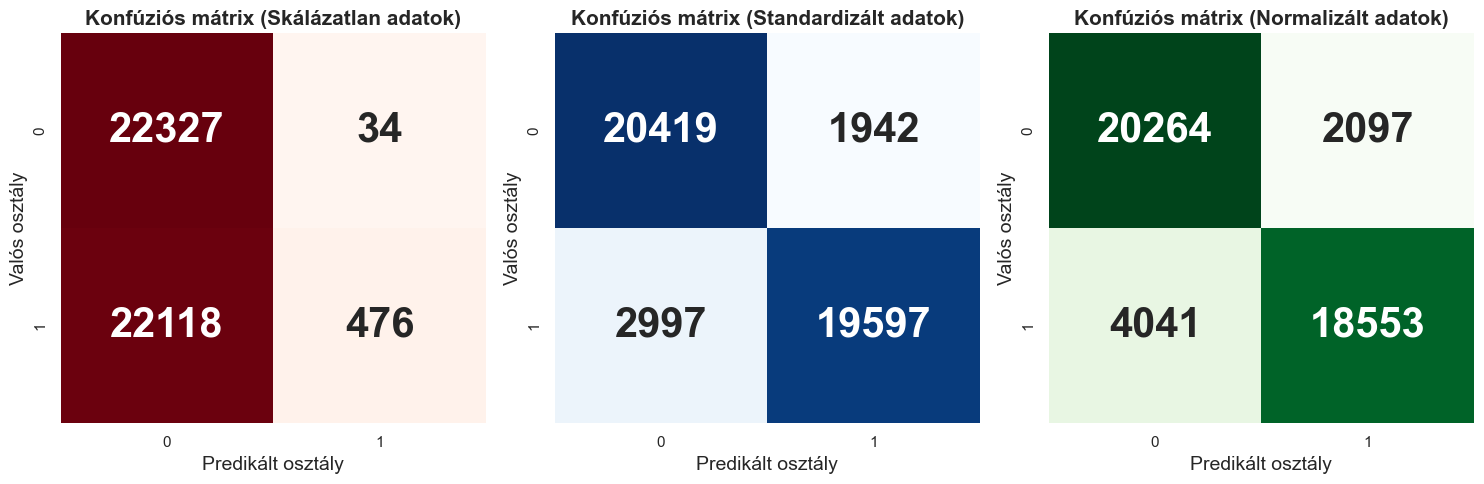

In [319]:
cm_s_nn = confusion_matrix(y_test_s, y_pred_s_nn)
cm_n_nn = confusion_matrix(y_test_n, y_pred_n_nn)
cm_e_nn = confusion_matrix(y_test_e, y_pred_e_nn)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(cm_e_nn, annot=True, cmap='Reds', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Skálázatlan adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 2)
sns.heatmap(cm_s_nn, annot=True, cmap='Blues', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Standardizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.subplot(1, 3, 3)
sns.heatmap(cm_n_nn, annot=True, cmap='Greens', annot_kws={"size": 30, "fontweight": "bold"}, fmt='g', cbar=False)
plt.title('Konfúziós mátrix (Normalizált adatok)', fontsize=15, fontweight='bold')
plt.xlabel('Predikált osztály', fontsize=14)
plt.ylabel('Valós osztály', fontsize=14)

plt.tight_layout()
plt.show()

In [320]:
y_proba_s_nn= np.argmax(y_proba_s_nn, axis=1)
y_proba_n_nn = np.argmax(y_proba_n_nn, axis=1)
y_proba_e_nn = np.argmax(y_proba_e_nn, axis=1)

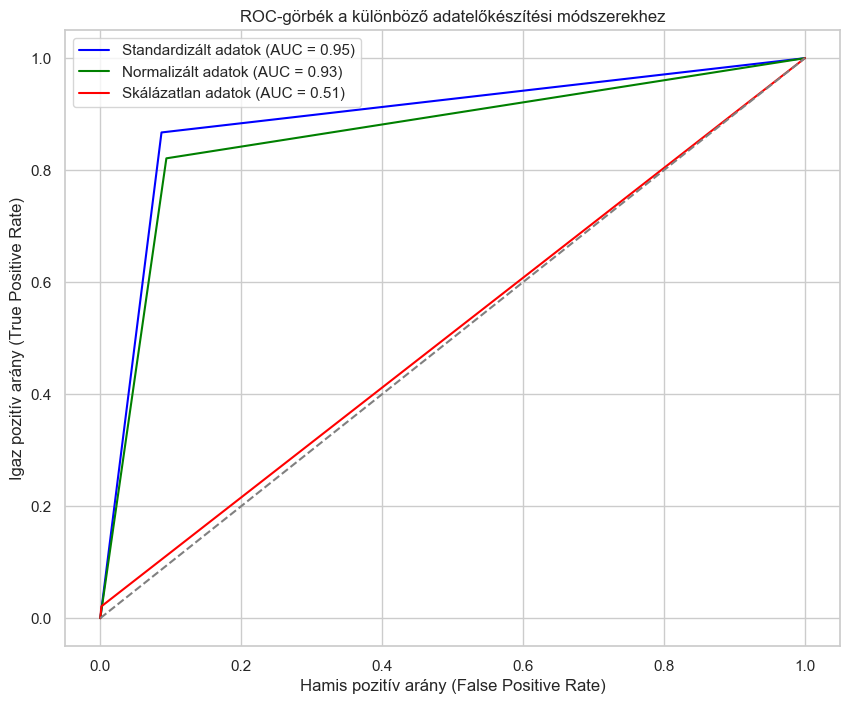

In [321]:
fpr_s, tpr_s, _ = roc_curve(y_test_s, y_proba_s_nn)
fpr_n, tpr_n, _ = roc_curve(y_test_n, y_proba_n_nn)
fpr_e, tpr_e, _ = roc_curve(y_test_e, y_proba_e_nn)

plt.figure(figsize=(10, 8))
plt.plot(fpr_s, tpr_s, color='blue', label=f'Standardizált adatok (AUC = {roc_auc_s_nn:.2f})')
plt.plot(fpr_n, tpr_n, color='green', label=f'Normalizált adatok (AUC = {roc_auc_n_nn:.2f})')
plt.plot(fpr_e, tpr_e, color='red', label=f'Skálázatlan adatok (AUC = {roc_auc_e_nn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC-görbék a különböző adatelőkészítési módszerekhez')
plt.xlabel('Hamis pozitív arány (False Positive Rate)')
plt.ylabel('Igaz pozitív arány (True Positive Rate)')
plt.legend()
plt.show()

## Összegzés

In [353]:
valtozonevek = [
    "accuracy_e_nn", "precision_e_nn", "recall_e_nn", "f1_e_nn", "mse_e_nn", "roc_auc_e_nn",
    "accuracy_s_nn", "precision_s_nn", "recall_s_nn", "f1_s_nn", "mse_s_nn", "roc_auc_s_nn",
    "accuracy_n_nn", "precision_n_nn", "recall_n_nn", "f1_n_nn", "mse_n_nn", "roc_auc_n_nn",
    "accuracy_e_lr", "precision_e_lr", "recall_e_lr", "f1_e_lr", "mse_e_lr", "roc_auc_e_lr",
    "accuracy_s_lr", "precision_s_lr", "recall_s_lr", "f1_s_lr", "mse_s_lr", "roc_auc_s_lr",
    "accuracy_n_lr", "precision_n_lr", "recall_n_lr", "f1_n_lr", "mse_n_lr", "roc_auc_n_lr",
    "accuracy_e_df", "precision_e_df", "recall_e_df", "f1_e_df", "mse_e_df", "roc_auc_e_df",
    "accuracy_s_df", "precision_s_df", "recall_s_df", "f1_s_df", "mse_s_df", "roc_auc_s_df",
    "accuracy_n_df", "precision_n_df", "recall_n_df", "f1_n_df", "mse_n_df", "roc_auc_n_df",
    "accuracy_e_rdf", "precision_e_rdf", "recall_e_rdf", "f1_e_rdf", "mse_e_rdf", "roc_auc_e_rdf",
    "accuracy_s_rdf", "precision_s_rdf", "recall_s_rdf", "f1_s_rdf", "mse_s_rdf", "roc_auc_s_rdf",
    "accuracy_n_rdf", "precision_n_rdf", "recall_n_rdf", "f1_n_rdf", "mse_n_rdf", "roc_auc_n_rdf",
    "accuracy_e_gt", "precision_e_gt", "recall_e_gt", "f1_e_gt", "mse_e_gt", "roc_auc_e_gt",
    "accuracy_s_gt", "precision_s_gt", "recall_s_gt", "f1_s_gt", "mse_s_gt", "roc_auc_s_gt",
    "accuracy_n_gt", "precision_n_gt", "recall_n_gt", "f1_n_gt", "mse_n_gt", "roc_auc_n_gt"
]


model_mapping = {
    "lr": "Logisztikus regresszió",
    "df": "Döntési fa",
    "rdf": "Regularizált döntési fa",
    "gt": "Gradiens turbózás",
    "nn": "Neurális háló"
}

data = {
    "Mérőszám": [],
    "Adatelőkészítés": [],
    "Modell": [],
    "Érték": []
}

for valtozo in valtozonevek:
    ertek = eval(valtozo)
    parts = valtozo.split('_')
    if(parts[0]=='roc'):
        data["Mérőszám"].append("Roc Auc")
        parts.pop(0)
    else:
        data["Mérőszám"].append(parts[0].capitalize())
    data["Adatelőkészítés"].append("Skálázatlan" if parts[1] == "e" else "Standardizált" if parts[1] == "s" else "Normalizált")
    data["Modell"].append(model_mapping[parts[2]])
    data["Érték"].append(ertek)


meroszamok = pd.DataFrame(data)
print(meroszamok)

     Mérőszám Adatelőkészítés             Modell     Érték
0    Accuracy     Skálázatlan      Neurális háló  0.507241
1   Precision     Skálázatlan      Neurális háló  0.718959
2      Recall     Skálázatlan      Neurális háló  0.507241
3          F1     Skálázatlan      Neurális háló  0.353184
4         Mse     Skálázatlan      Neurális háló  0.492759
..        ...             ...                ...       ...
85  Precision     Normalizált  Gradiens turbózás  0.930326
86     Recall     Normalizált  Gradiens turbózás  0.930264
87         F1     Normalizált  Gradiens turbózás  0.930263
88        Mse     Normalizált  Gradiens turbózás  0.069736
89    Roc Auc     Normalizált  Gradiens turbózás  0.495824

[90 rows x 4 columns]


In [354]:
meroszamok['Modell_Adat'] = meroszamok['Modell'] + ' - ' + meroszamok['Adatelőkészítés']

In [355]:
meroszamok.to_csv('meroszamok.csv', index=False, encoding='utf-8')

In [356]:
meroszamok.to_excel('meroszamok.xlsx', index=False, encoding='utf-8')

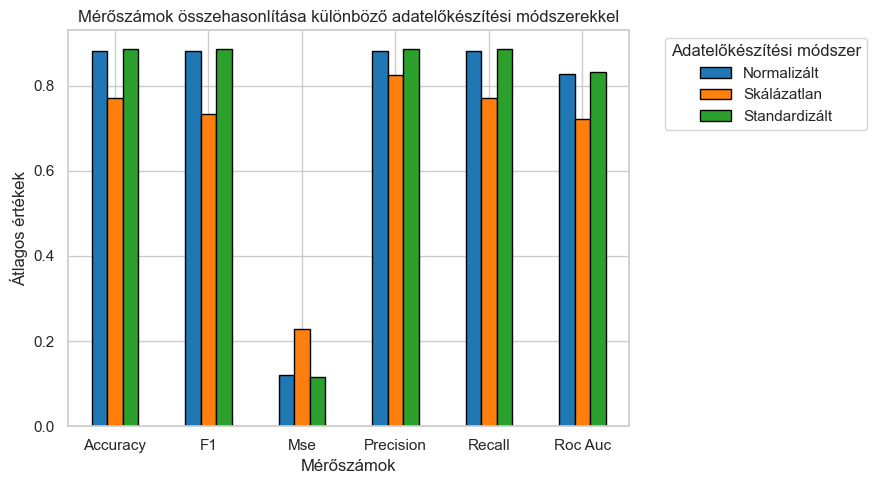

In [357]:
sns.set(style="whitegrid")
colors = sns.color_palette("tab10")
meroszamok.groupby(['Mérőszám', 'Adatelőkészítés'])['Érték'].mean().unstack().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Mérőszámok összehasonlítása különböző adatelőkészítési módszerekkel')
plt.xlabel('Mérőszámok')
plt.xticks(rotation=0)
plt.ylabel('Átlagos értékek')
plt.legend(title='Adatelőkészítési módszer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().set_size_inches(9, 5)
plt.tight_layout()
plt.show()

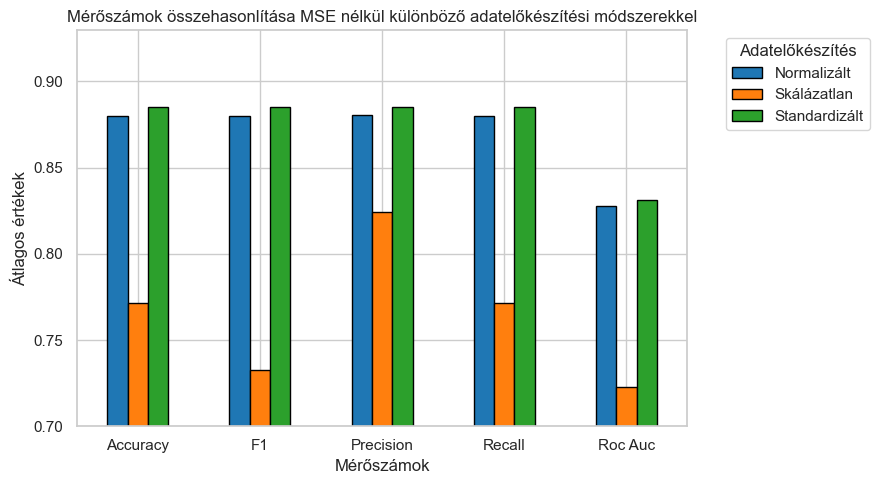

In [358]:
meroszamok[meroszamok['Mérőszám'] != 'Mse'].groupby(['Mérőszám', 'Adatelőkészítés'])['Érték'].mean().unstack().plot(kind='bar', color=colors, edgecolor='black')
plt.title('Mérőszámok összehasonlítása MSE nélkül különböző adatelőkészítési módszerekkel')
plt.xlabel('Mérőszámok')
plt.ylabel('Átlagos értékek')
plt.xticks(rotation=0)
plt.ylim(0.7, plt.ylim()[1])
plt.legend(title='Adatelőkészítés', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gcf().set_size_inches(9, 5)
plt.tight_layout()
plt.show()

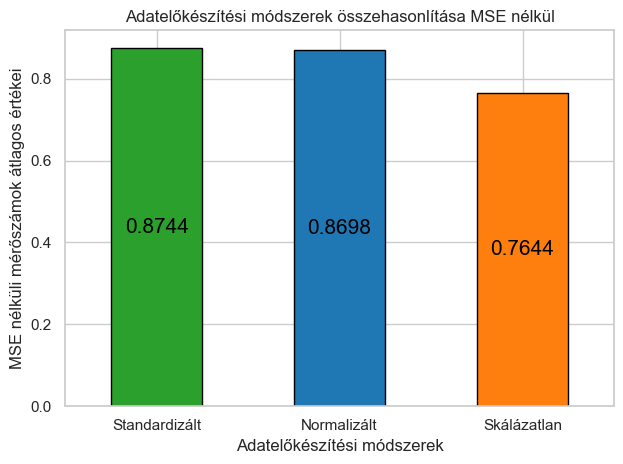

In [359]:
modszerek = meroszamok[meroszamok['Mérőszám'] != 'Mse'].groupby('Adatelőkészítés')['Érték'].mean().sort_values(ascending=False)
szinekjol = ['#2ca02c', '#1f77b4', '#ff7f0e' ]
bar_plot = modszerek.plot(kind='bar', color=szinekjol, edgecolor='black')
for index, value in enumerate(modszerek):
    plt.text(index, value / 2, f'{value:.4f}', ha='center', va='center', color='black', fontsize=15)
plt.title('Adatelőkészítési módszerek összehasonlítása MSE nélkül')
plt.xlabel('Adatelőkészítési módszerek')
plt.ylabel('MSE nélküli mérőszámok átlagos értékei')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

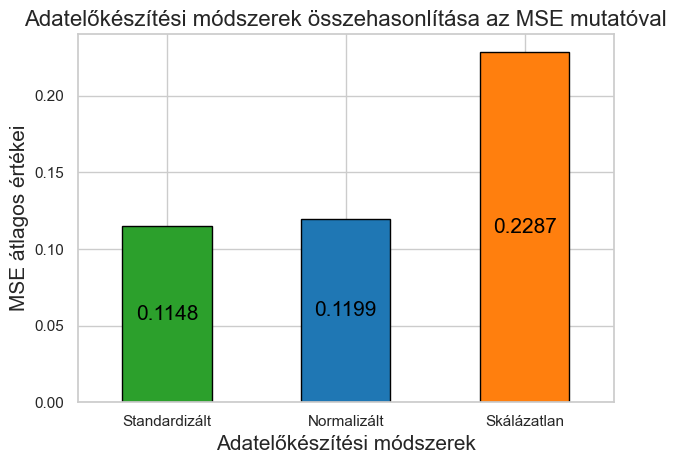

In [360]:
modszerek = meroszamok[meroszamok['Mérőszám'] == 'Mse'].groupby('Adatelőkészítés')['Érték'].mean().sort_values(ascending=True)
bar_plot = modszerek.plot(kind='bar', color=szinekjol, edgecolor='black')
for index, value in enumerate(modszerek):
    plt.text(index, value / 2, f'{value:.4f}', ha='center', va='center', color='black', fontsize=15)
plt.title('Adatelőkészítési módszerek összehasonlítása az MSE mutatóval', fontsize=16)
plt.xlabel('Adatelőkészítési módszerek',fontsize=15)
plt.ylabel('MSE átlagos értékei',fontsize=15)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

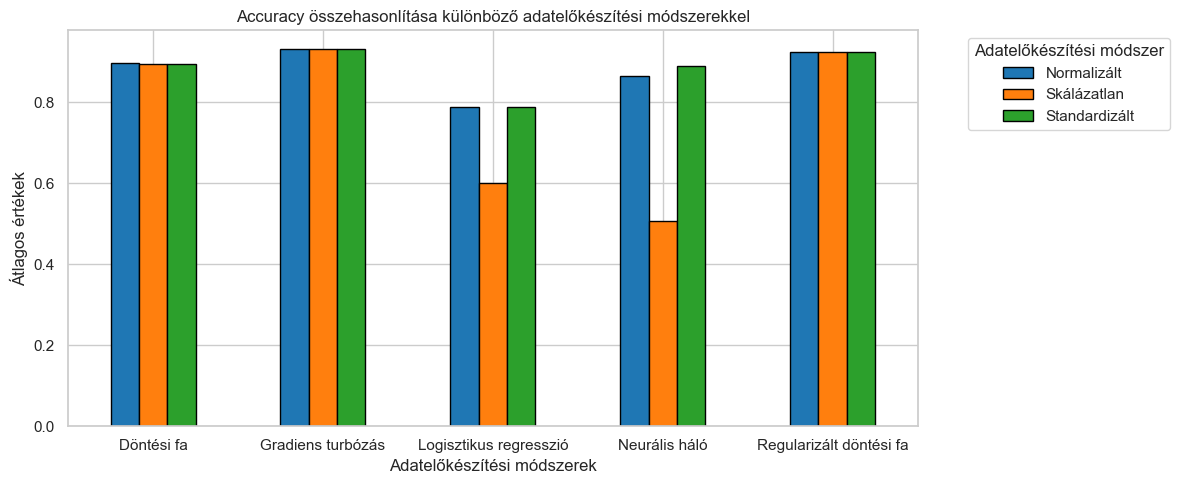

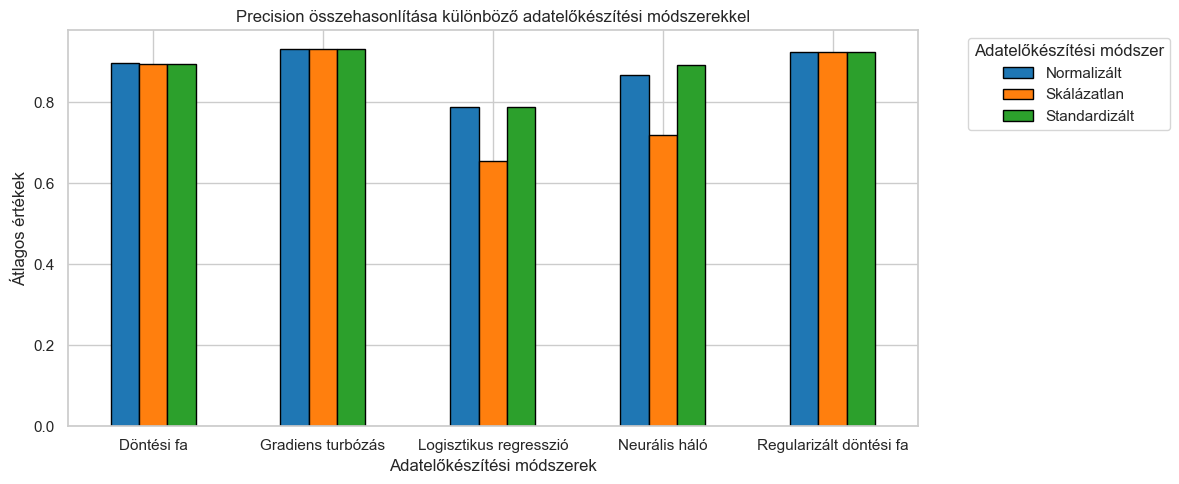

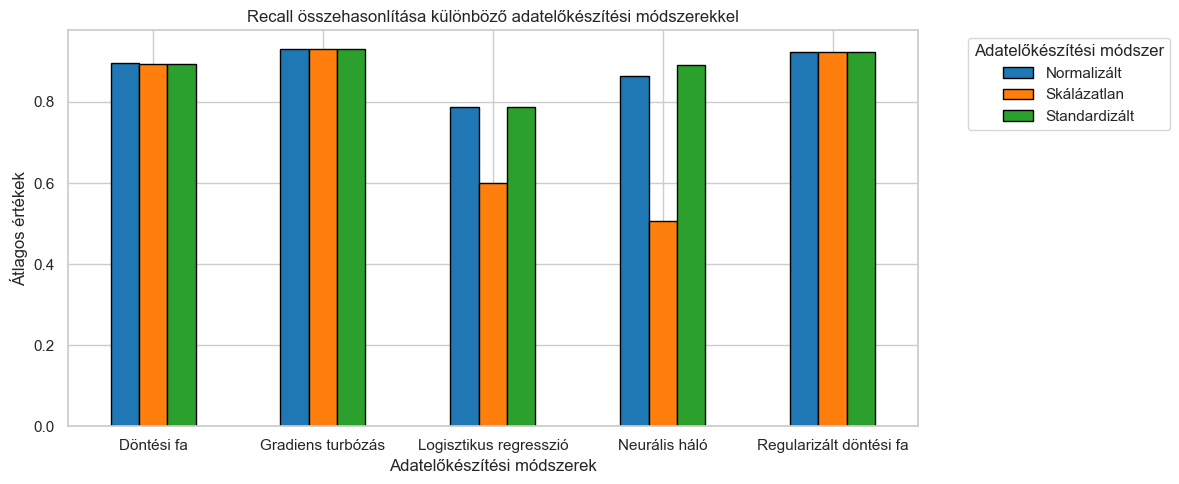

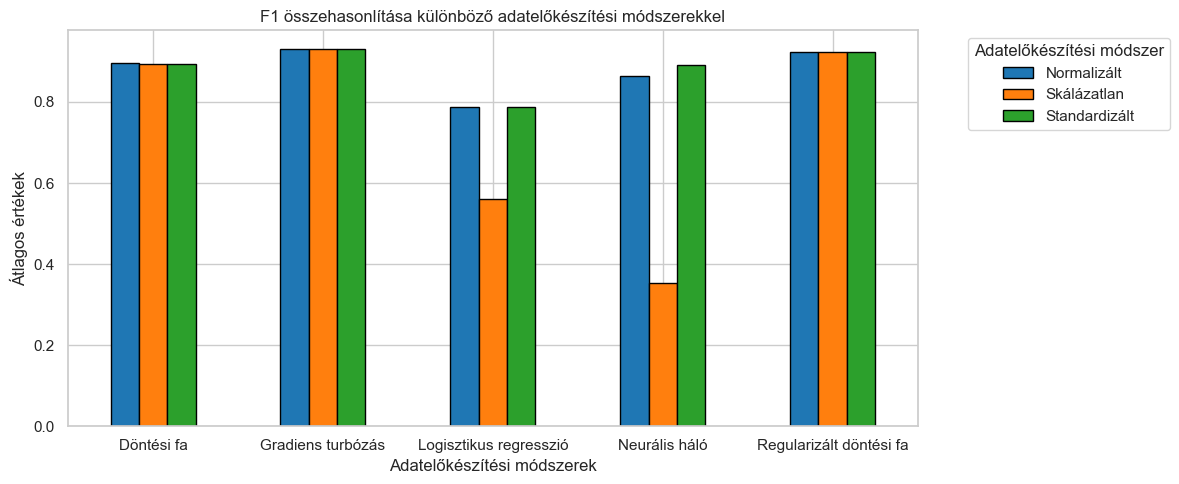

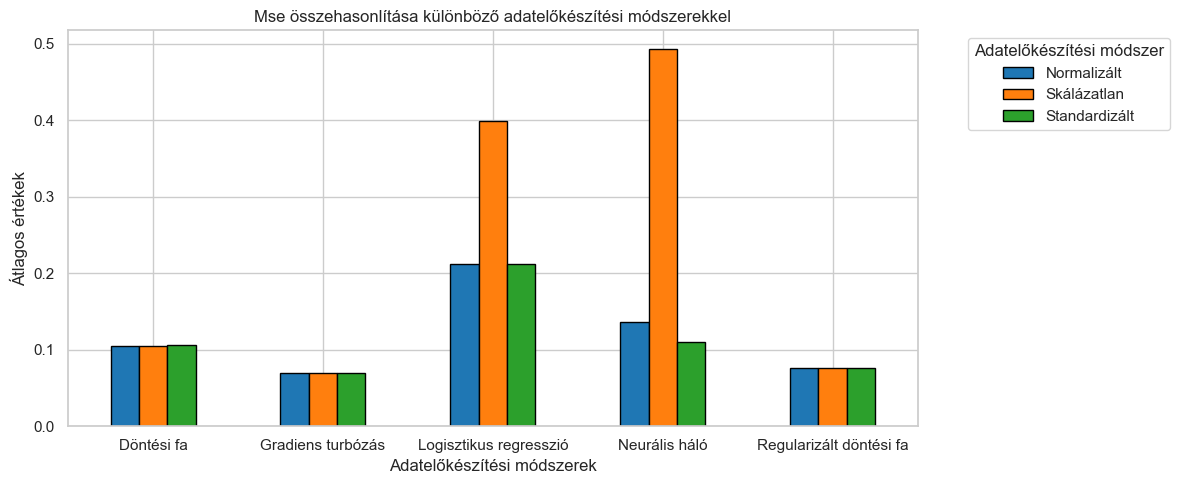

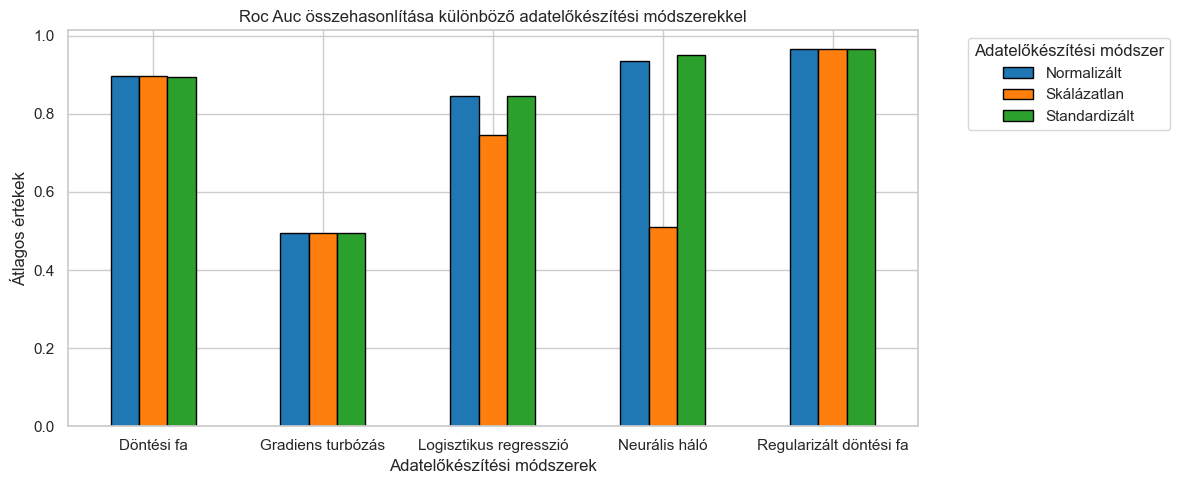

In [361]:
meroszamok_lista = meroszamok['Mérőszám'].unique()

for meroszam in meroszamok_lista:
    adatok = meroszamok[meroszamok['Mérőszám'] == meroszam]
    atlagok = adatok.groupby(['Modell','Adatelőkészítés'])['Érték'].mean().unstack()
    atlagok.plot(kind='bar', color=colors, edgecolor='black')
    plt.title(f'{meroszam} összehasonlítása különböző adatelőkészítési módszerekkel')
    plt.xlabel('Adatelőkészítési módszerek')
    plt.ylabel('Átlagos értékek')
    plt.legend(title='Adatelőkészítési módszer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.gcf().set_size_inches(12, 5)
    plt.tight_layout()
    plt.show()


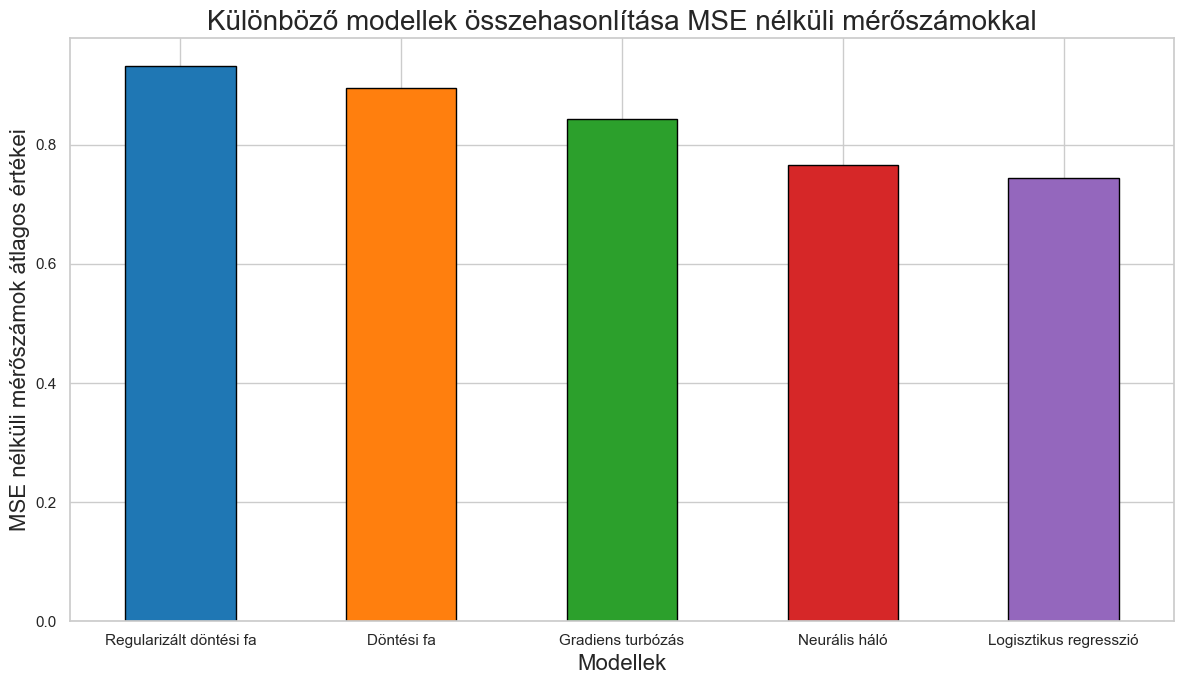

In [362]:
plt.figure(figsize=(10,5))
meroszamok[meroszamok['Mérőszám'] != 'Mse'].groupby(['Modell'])['Érték'].mean().sort_values(ascending=False).plot(kind='bar', color=colors, edgecolor='black')
plt.title('Különböző modellek összehasonlítása MSE nélküli mérőszámokkal', fontsize=20)
plt.xlabel('Modellek',fontsize=16)
plt.xticks(rotation=0)
plt.ylabel('MSE nélküli mérőszámok átlagos értékei', fontsize=16)
plt.gcf().set_size_inches(12, 7)
plt.tight_layout()
plt.show()

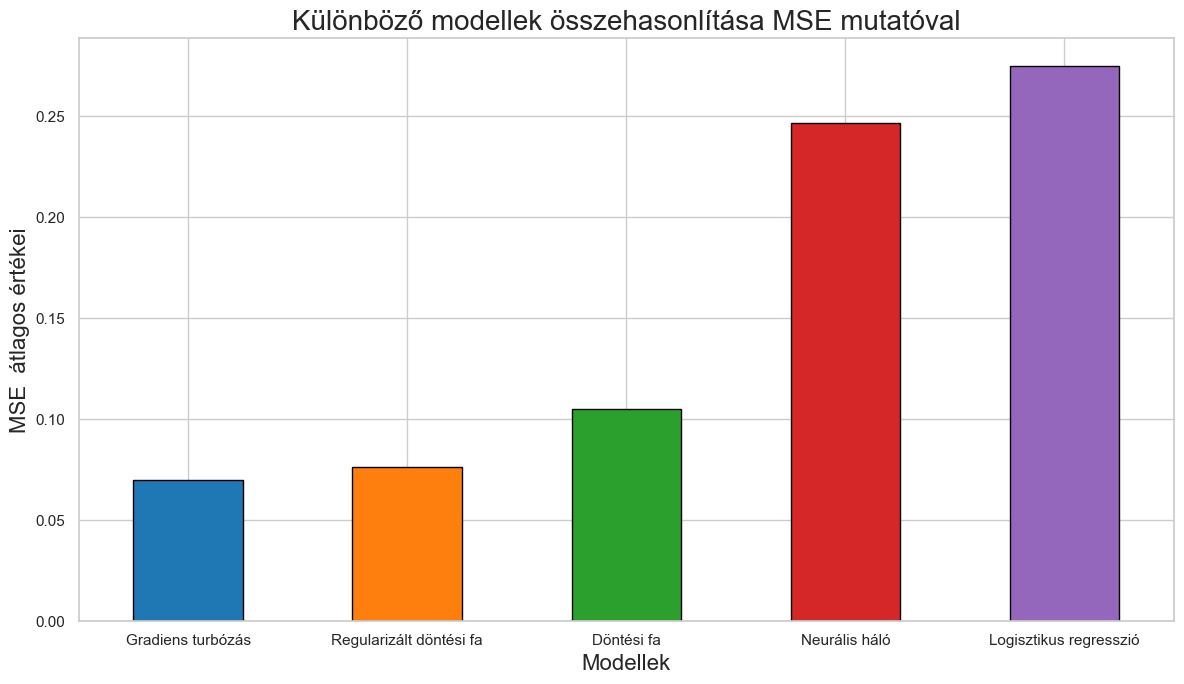

In [363]:
plt.figure(figsize=(10,5))
meroszamok[meroszamok['Mérőszám'] == 'Mse'].groupby(['Modell'])['Érték'].mean().sort_values(ascending=True).plot(kind='bar', color=colors, edgecolor='black')
plt.title('Különböző modellek összehasonlítása MSE mutatóval', fontsize=20)
plt.xlabel('Modellek',fontsize=16)
plt.xticks(rotation=0)
plt.ylabel('MSE  átlagos értékei',fontsize=16)
plt.gcf().set_size_inches(12, 7)
plt.tight_layout()
plt.show()

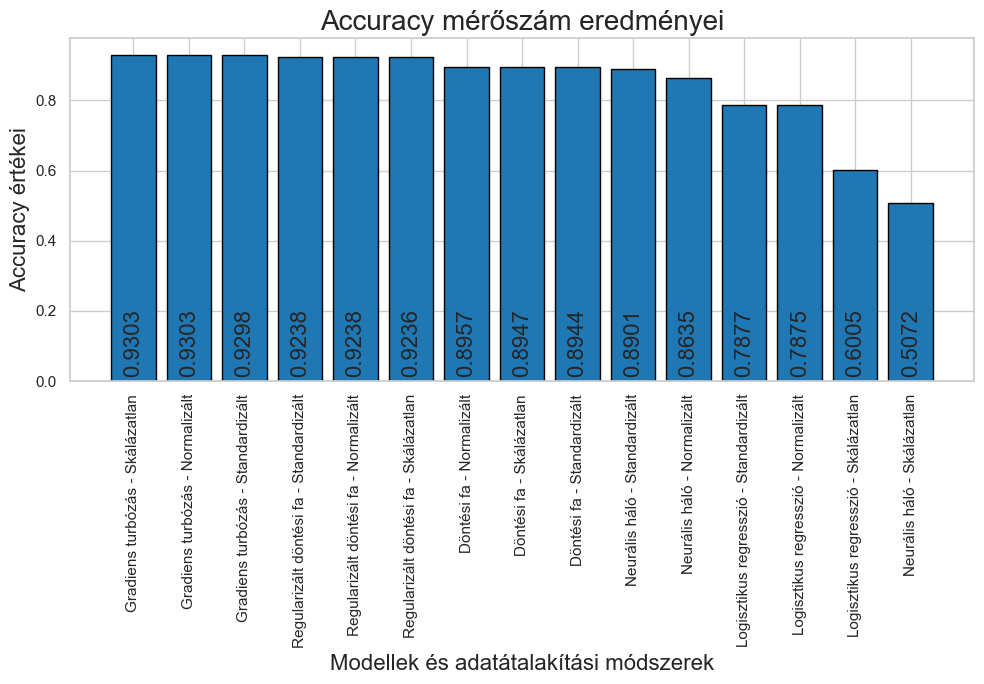

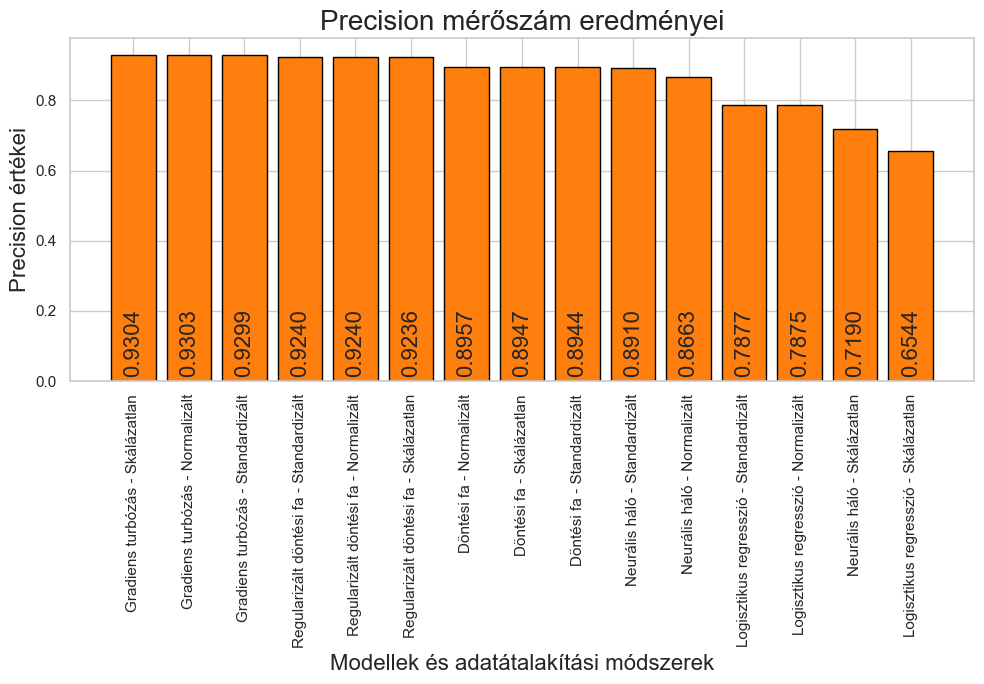

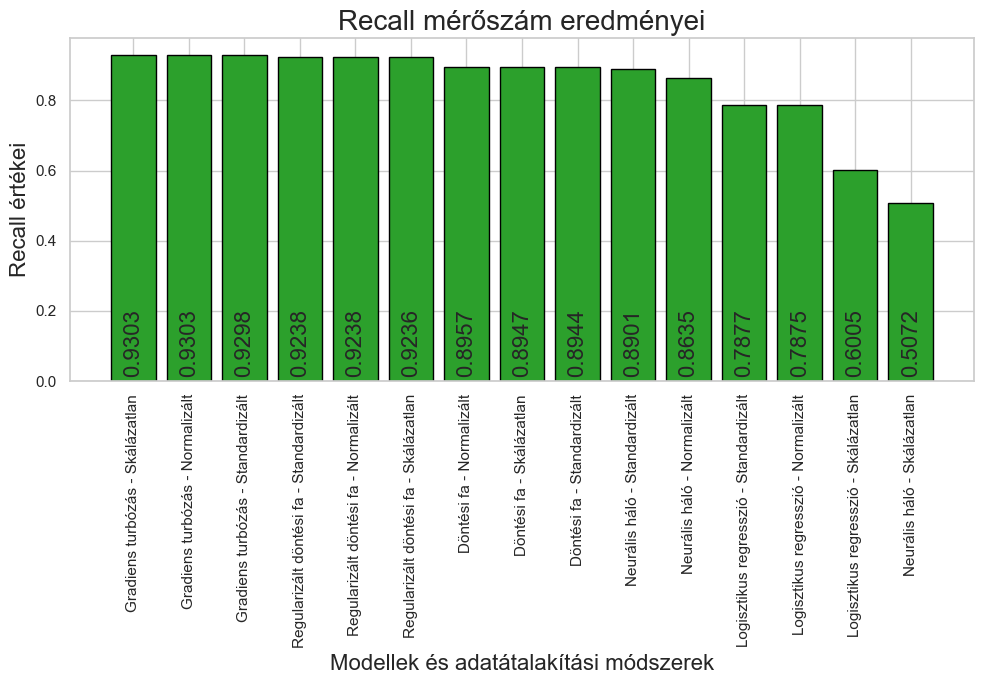

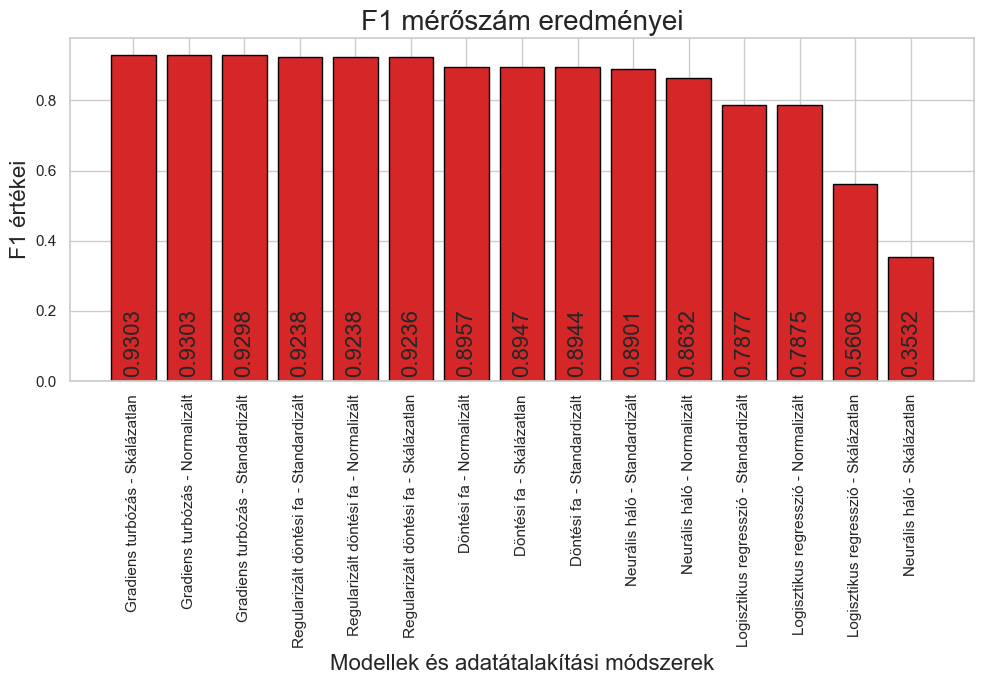

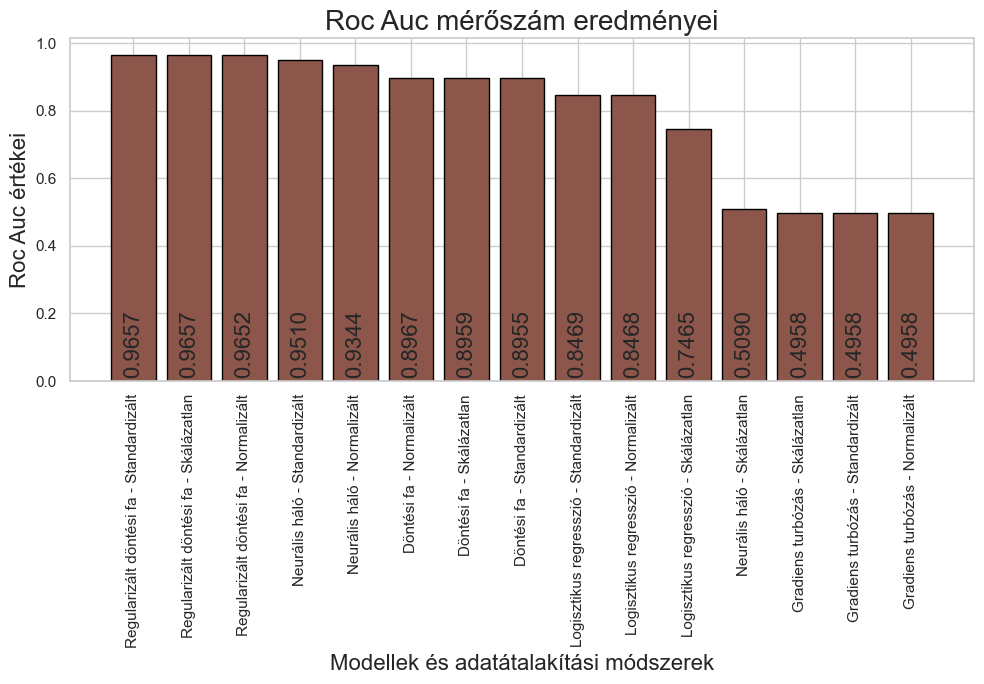

In [364]:
meroszamok_list = meroszamok['Mérőszám'].unique()
for i, meroszam in enumerate(meroszamok_list):
    if meroszam != 'Mse':
        data = meroszamok[meroszamok['Mérőszám'] == meroszam].sort_values('Érték', ascending=False)
        plt.figure(figsize=(10, 7))
        bars = plt.bar(data['Modell_Adat'], data['Érték'], color=colors[i % len(colors)], edgecolor='black')
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, 0.01, f'{yval:.4f}', ha='center', va='bottom', rotation=90, fontsize=16)
        plt.title(f'{meroszam} mérőszám eredményei', fontsize=20)
        plt.xlabel('Modellek és adatátalakítási módszerek', fontsize=16)
        plt.xticks(rotation=90)
        plt.ylabel(f'{meroszam} értékei', fontsize=16)
        plt.tight_layout()
        plt.show()


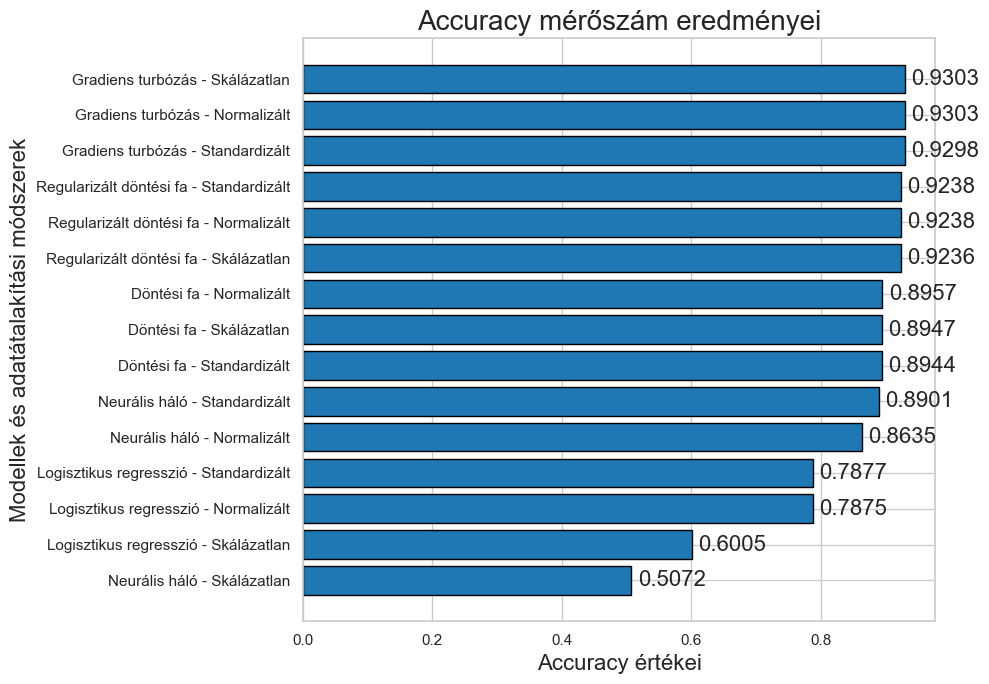

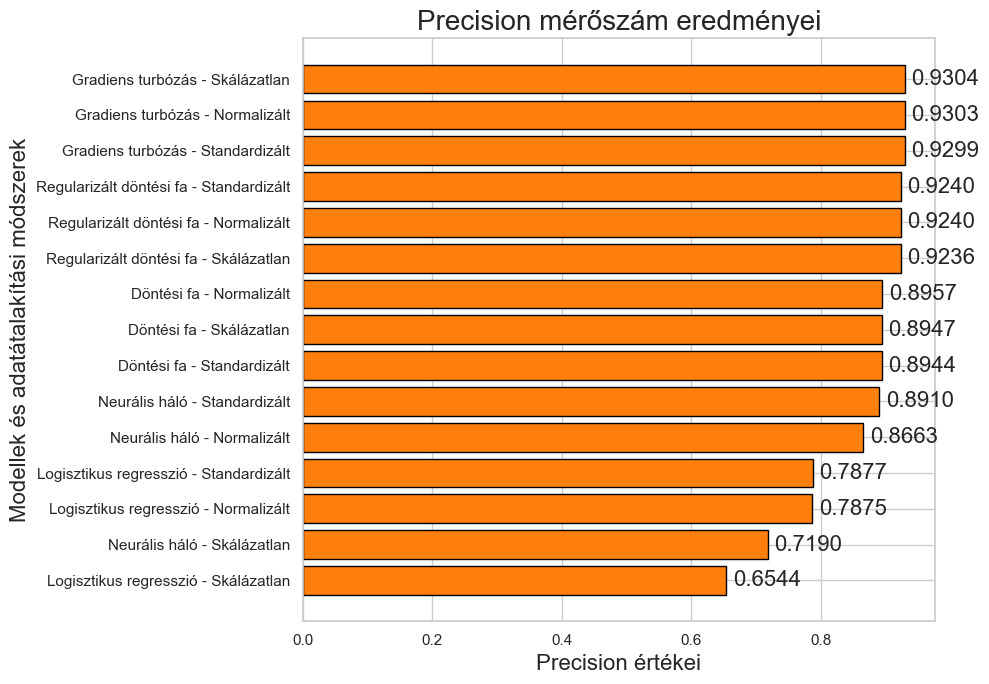

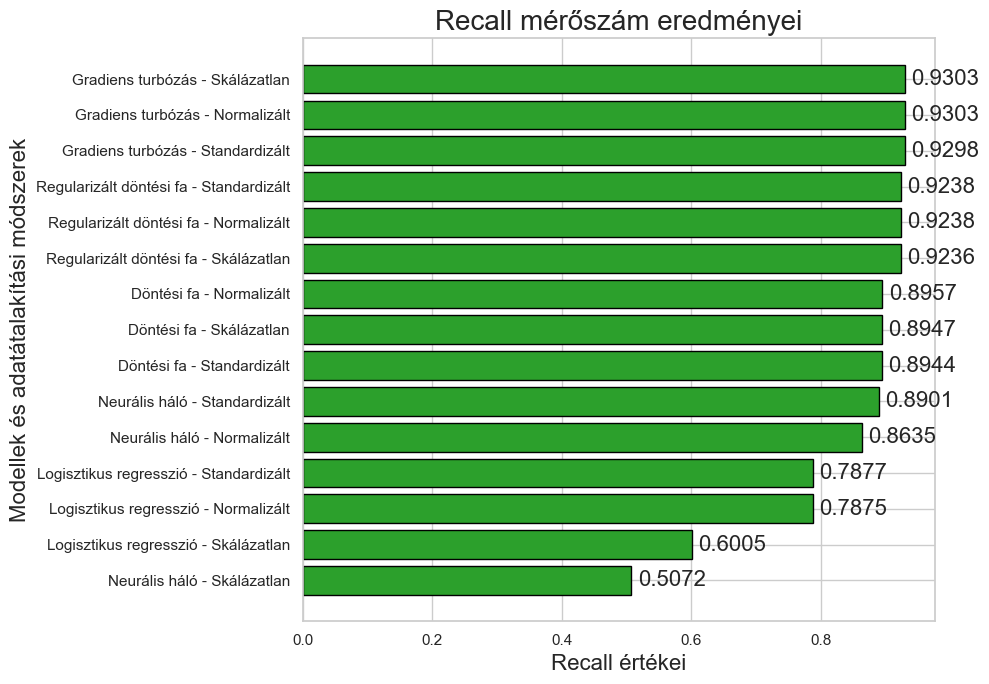

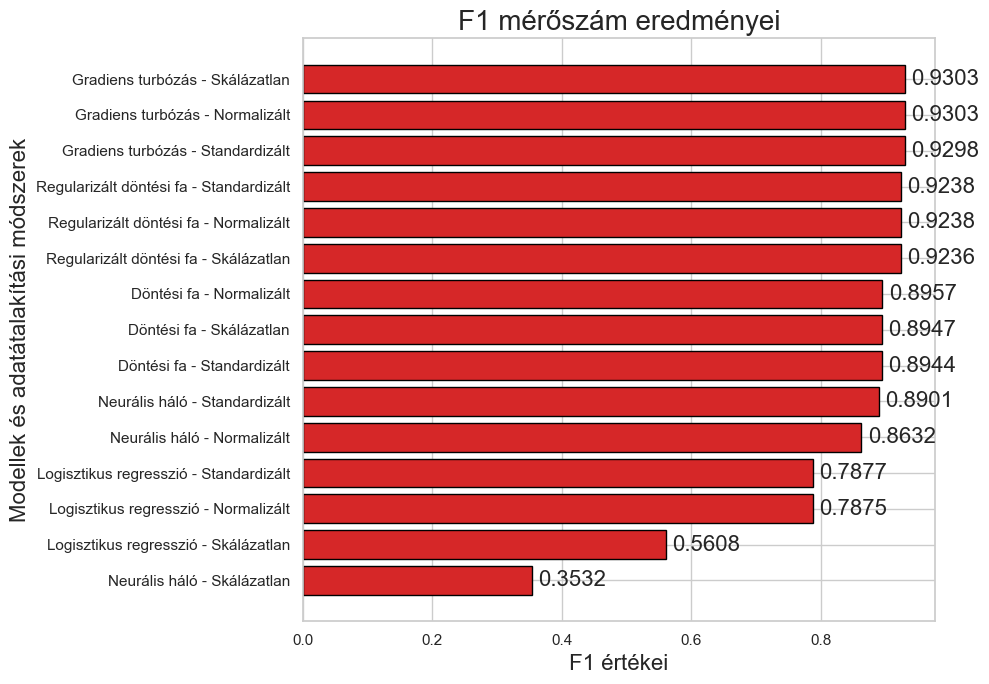

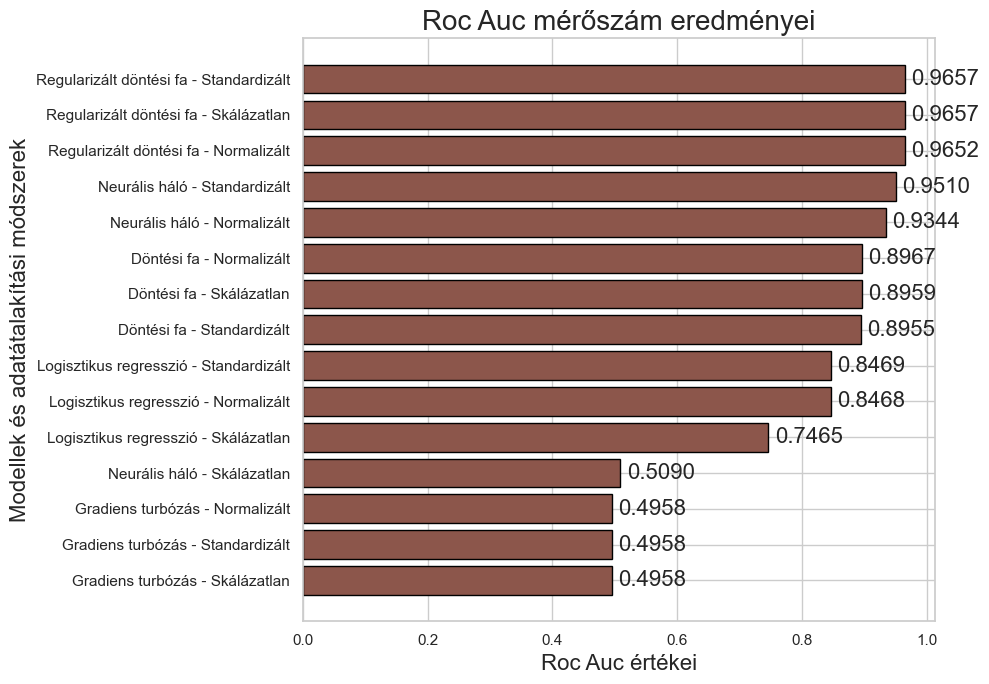

In [365]:
meroszamok_list = meroszamok['Mérőszám'].unique()
for i, meroszam in enumerate(meroszamok_list):
    if meroszam != 'Mse':
        data = meroszamok[meroszamok['Mérőszám'] == meroszam].sort_values('Érték', ascending=True)
        plt.figure(figsize=(10, 7))
        bars = plt.barh(data['Modell_Adat'], data['Érték'], color=colors[i % len(colors)], edgecolor='black')
        for bar in bars:
            xval = bar.get_width()
            plt.text(xval + 0.01, bar.get_y() + bar.get_height()/2, f'{xval:.4f}', 
                     va='center', ha='left', fontsize=16)
        
        plt.title(f'{meroszam} mérőszám eredményei', fontsize=20)
        plt.ylabel('Modellek és adatátalakítási módszerek', fontsize=16)  # Tengelycím csere
        plt.xlabel(f'{meroszam} értékei', fontsize=16)  # Tengelycím csere
        plt.tight_layout()
        plt.show()

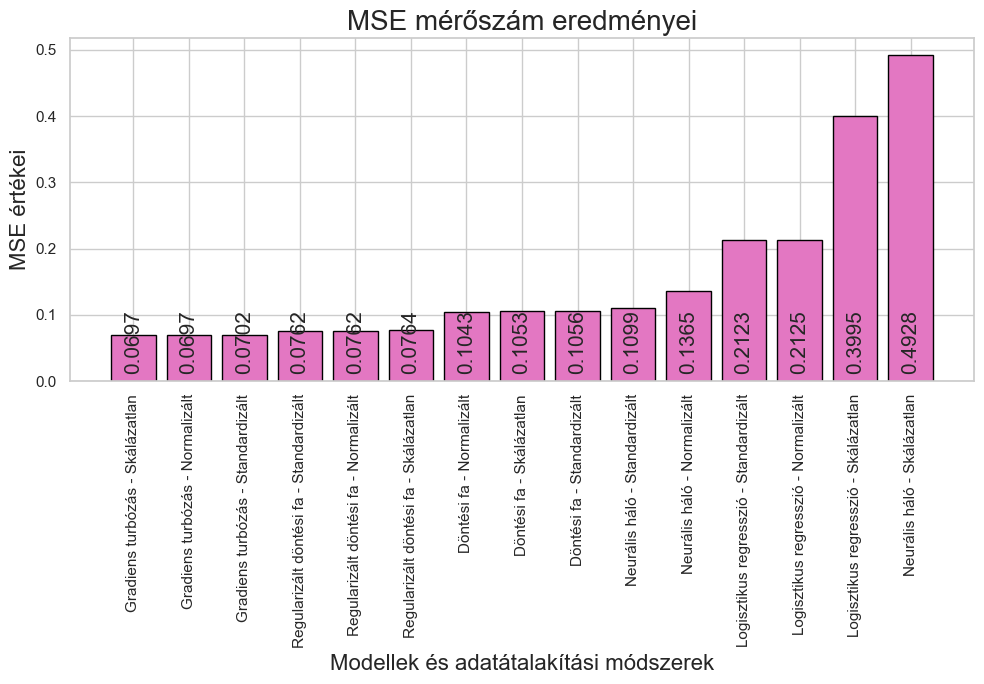

In [366]:
meroszamok['Modell_Adat'] = meroszamok['Modell'] + ' - ' + meroszamok['Adatelőkészítés']
accuracy_data = meroszamok[meroszamok['Mérőszám'] == 'Mse'].sort_values('Érték', ascending=True)
plt.figure(figsize=(10, 7))
bars = plt.bar(accuracy_data['Modell_Adat'], accuracy_data['Érték'], color=colors[6], edgecolor='black')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, 0.01, f'{yval:.4f}', ha='center', va='bottom', rotation=90, fontsize=15)
plt.title('MSE mérőszám eredményei', fontsize=20)
plt.xlabel('Modellek és adatátalakítási módszerek', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('MSE értékei', fontsize=16)
plt.tight_layout()
plt.show()

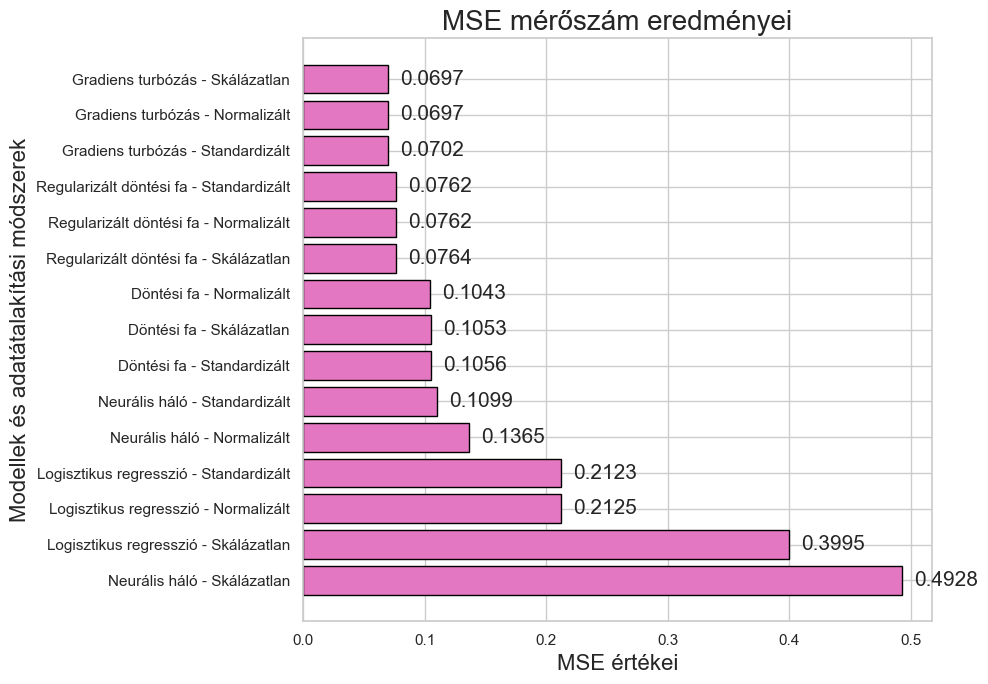

In [367]:
accuracy_data = meroszamok[meroszamok['Mérőszám'] == 'Mse'].sort_values('Érték', ascending=False)
plt.figure(figsize=(10, 7))
bars = plt.barh(accuracy_data['Modell_Adat'], accuracy_data['Érték'], color=colors[6], edgecolor='black')
for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 0.01, bar.get_y() + bar.get_height()/2, f'{xval:.4f}', 
             va='center', ha='left', fontsize=15)
plt.title('MSE mérőszám eredményei', fontsize=20)
plt.ylabel('Modellek és adatátalakítási módszerek', fontsize=16)
plt.xlabel('MSE értékei', fontsize=16)
plt.tight_layout()
plt.show()

In [368]:
tanulasi_idok_reszletes = {
    "Logisztikus regresszió - Standardizált": training_time_lr_s,
    "Logisztikus regresszió - Skálázatlan": training_time_lr_e,
    "Logisztikus regresszió - Normalizált": training_time_lr_n,
    "Döntési fa - Standardizált": training_time_df_s,
    "Döntési fa - Skálázatlan": training_time_df_e,
    "Döntési fa - Normalizált": training_time_df_n,
    "Regularizált döntési fa - Standardizált": training_time_rdf_s,
    "Regularizált döntési fa - Skálázatlan": training_time_rdf_e,
    "Regularizált döntési fa - Normalizált": training_time_rdf_n,
    "Gradiens turbózás - Standardizált": training_time_gt_s,
    "Gradiens turbózás - Skálázatlan": training_time_gt_e,
    "Gradiens turbózás - Normalizált": training_time_gt_n,
    "Neurális háló - Standardizált": training_time_nn_s,
    "Neurális háló - Skálázatlan": training_time_nn_e,
    "Neurális háló - Normalizált": training_time_nn_n
}

In [369]:
idok = []
for key, value in tanulasi_idok_reszletes.items():
    modell, adatelokeszites = key.rsplit(' - ', 1)
    idok.append({
        'Modell': modell,
        'Adatelőkészítési módszer': adatelokeszites,
        'Tanulási Idő': value,
        'Modell-Adatelőkészítés': key
    })

tanulasi_idok = pd.DataFrame(idok)

<Figure size 1300x1000 with 0 Axes>

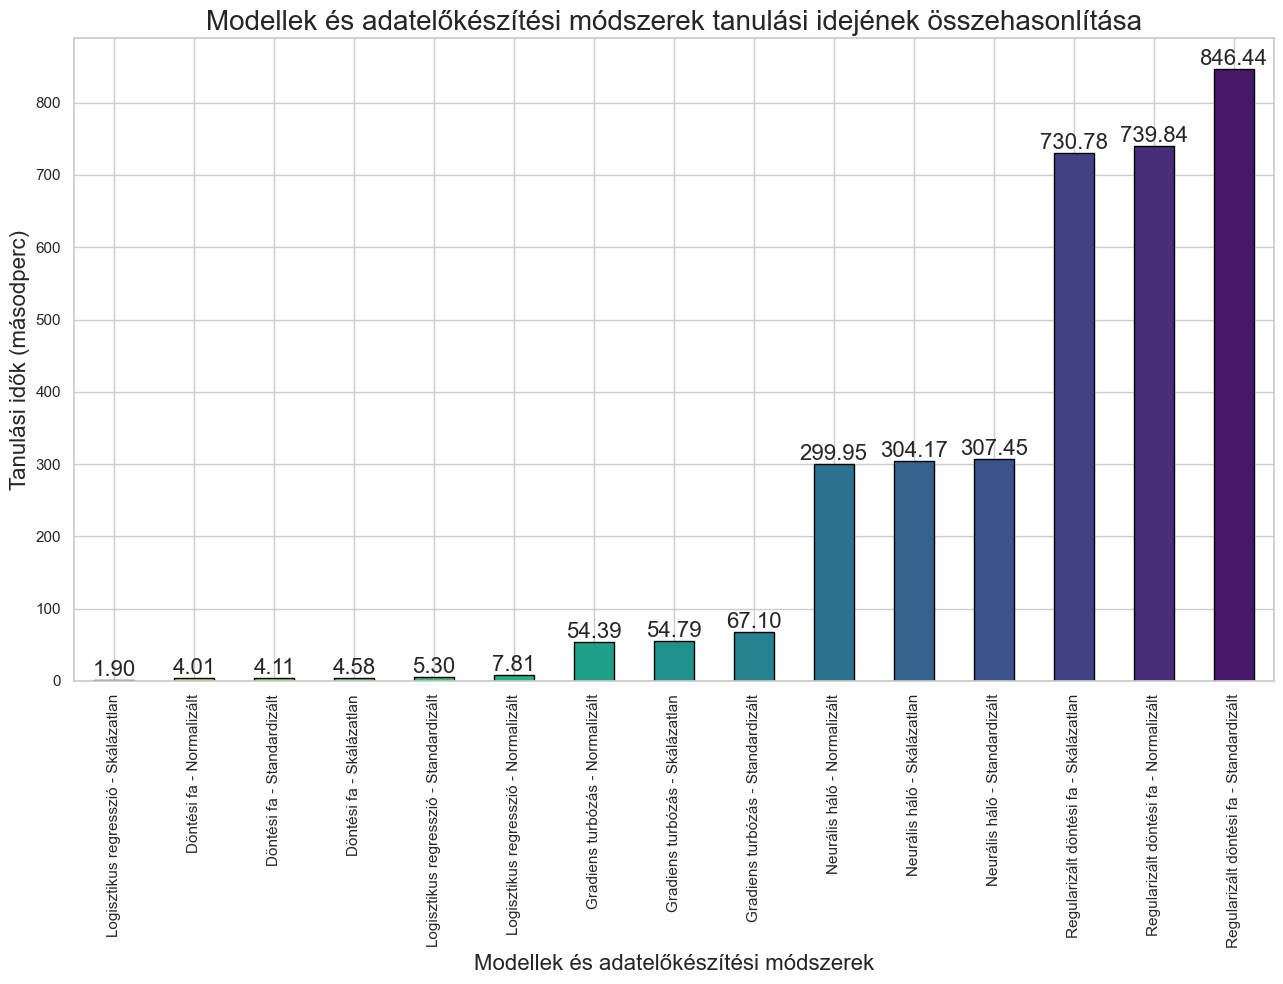

In [370]:
colors = sns.color_palette("viridis", n_colors=len(tanulasi_idok))[::-1]
plt.figure(figsize=(13, 10))
bars = tanulasi_idok.sort_values(by='Tanulási Idő', ascending=True).plot(
    kind='bar',
    x='Modell-Adatelőkészítés',
    y='Tanulási Idő',
    color=colors,
    edgecolor='black',
    legend=False
)
plt.title('Modellek és adatelőkészítési módszerek tanulási idejének összehasonlítása', fontsize=20)
plt.xlabel('Modellek és adatelőkészítési módszerek', fontsize=16)
plt.ylabel('Tanulási idők (másodperc)', fontsize=16)
plt.xticks(rotation=90, ha='center')
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f}', ha='center', va='bottom', fontsize=16)
plt.gcf().set_size_inches(13, 10)
plt.tight_layout()
plt.show()

<Figure size 1300x1000 with 0 Axes>

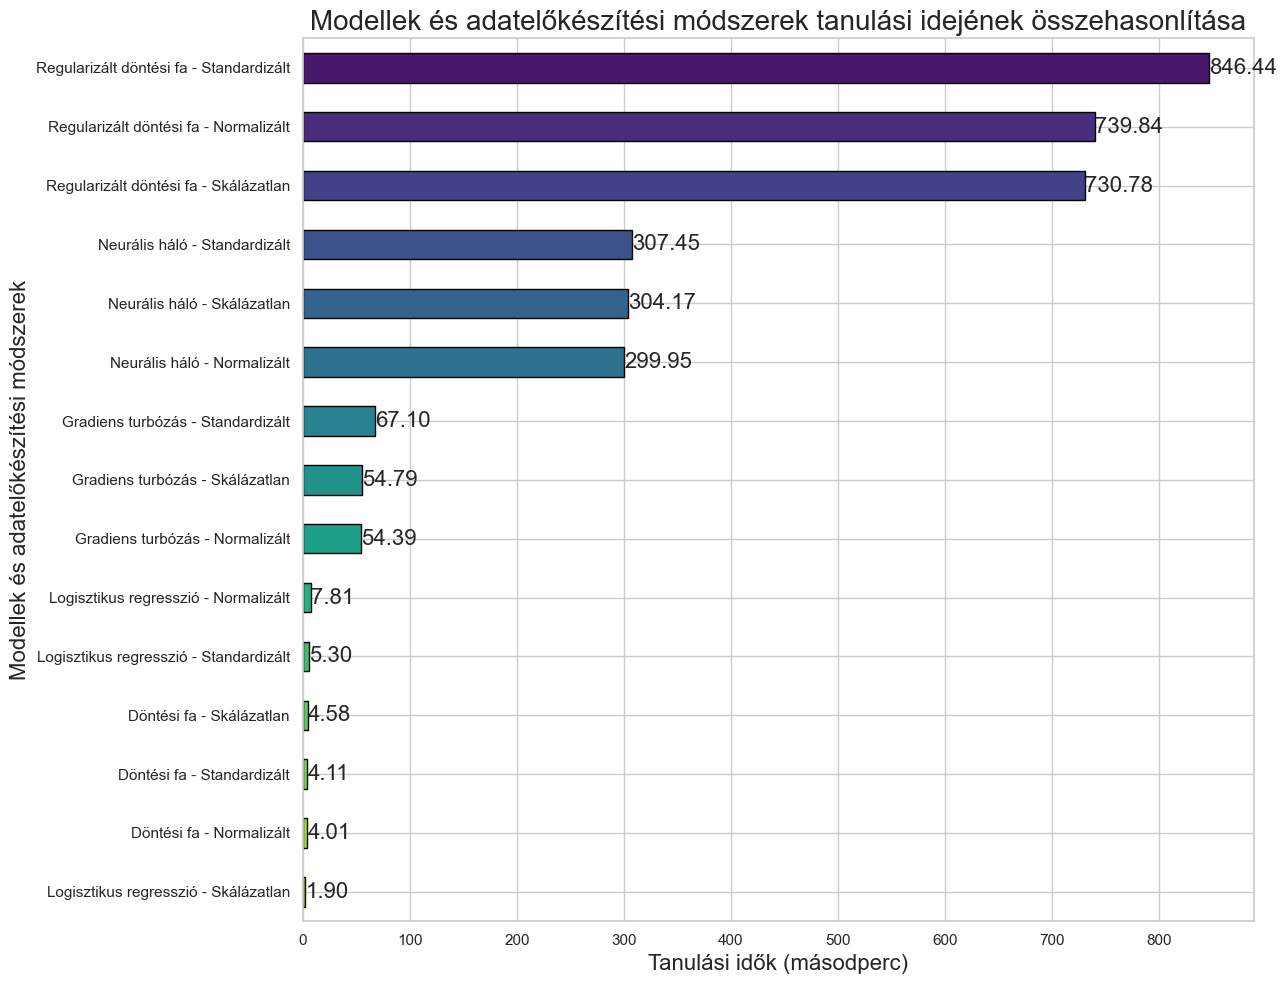

In [371]:
colors = sns.color_palette("viridis", n_colors=len(tanulasi_idok))[::-1]
plt.figure(figsize=(13, 10))
bars = tanulasi_idok.sort_values(by='Tanulási Idő', ascending=True).plot(
    kind='barh',
    x='Modell-Adatelőkészítés',
    y='Tanulási Idő',
    color=colors,
    edgecolor='black',
    legend=False
)
plt.title('Modellek és adatelőkészítési módszerek tanulási idejének összehasonlítása', fontsize=20)
plt.ylabel('Modellek és adatelőkészítési módszerek', fontsize=16)  # Az x helyett most az y tengelyen van
plt.xlabel('Tanulási idők (másodperc)', fontsize=16)  # A y helyett most az x tengelyen van
for bar in bars.patches:
    width = bar.get_width()  # Szélesség, mivel vízszintes oszlopokról van szó
    plt.text(width + 0.1, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
             ha='left', va='center', fontsize=16)
plt.gcf().set_size_inches(13, 10)
plt.tight_layout()
plt.show()

<Figure size 1300x1000 with 0 Axes>

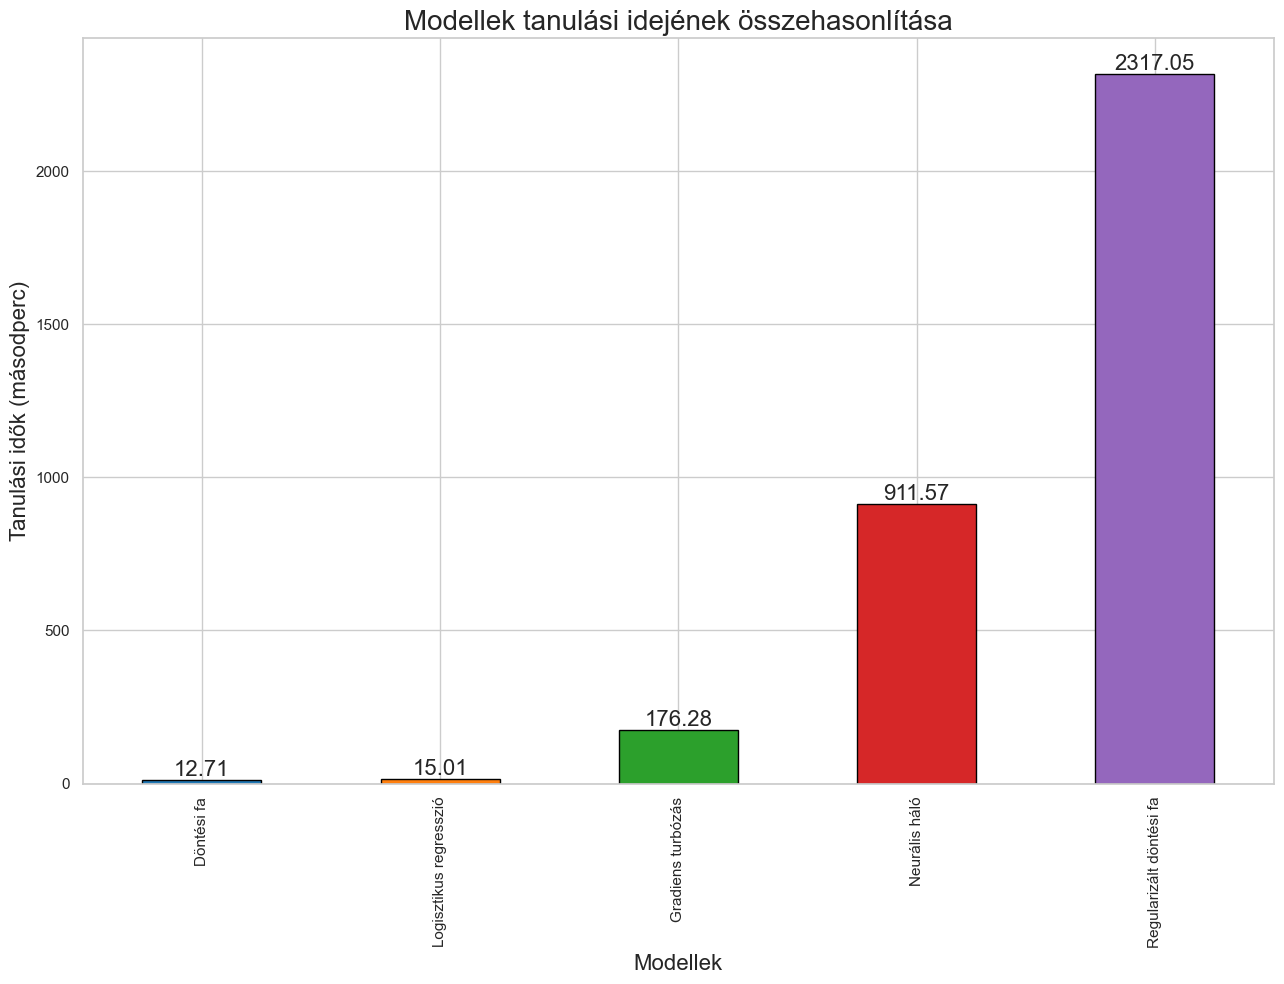

In [372]:
df=tanulasi_idok[['Modell', 'Tanulási Idő']].groupby('Modell').sum().sort_values(by='Tanulási Idő',ascending=True)
df=df.reset_index()
colors = sns.color_palette("tab10")
plt.figure(figsize=(13, 10))
bars = df.sort_values(by='Tanulási Idő', ascending=True).plot(
    kind='bar',
    x='Modell',
    y='Tanulási Idő',
    color=colors,
    edgecolor='black',
    legend=False
)
plt.title('Modellek tanulási idejének összehasonlítása', fontsize=20)
plt.xlabel('Modellek', fontsize=16)
plt.ylabel('Tanulási idők (másodperc)', fontsize=16)
plt.xticks(rotation=90, ha='center')
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f}', ha='center', va='bottom', fontsize=16)
plt.gcf().set_size_inches(13, 10)
plt.tight_layout()
plt.show()

<Figure size 1300x1000 with 0 Axes>

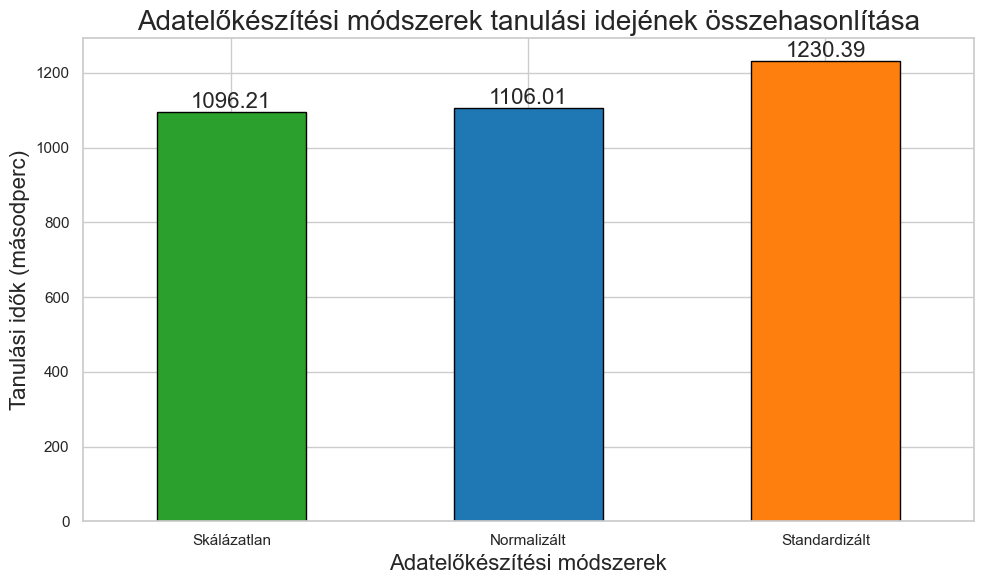

In [373]:
df=tanulasi_idok[['Adatelőkészítési módszer', 'Tanulási Idő']].groupby('Adatelőkészítési módszer').sum().sort_values(by='Tanulási Idő',ascending=True)
df=df.reset_index()
plt.figure(figsize=(13, 10))
bars = df.sort_values(by='Tanulási Idő', ascending=True).plot(
    kind='bar',
    x='Adatelőkészítési módszer',
    y='Tanulási Idő',
    color=szinekjol,
    edgecolor='black',
    legend=False
)
plt.title('Adatelőkészítési módszerek tanulási idejének összehasonlítása', fontsize=20)
plt.xlabel('Adatelőkészítési módszerek', fontsize=16)
plt.ylabel('Tanulási idők (másodperc)', fontsize=16)
plt.xticks(rotation=0, ha='center')
for bar in bars.patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f}', ha='center', va='bottom', fontsize=16)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
plt.show()

## Prediktálás

In [204]:
data = {
    'State': ['TX', 'WA', 'NC', 'FL', 'FL'],
    'NAICS': [44, 45, 44, 55, 53],
    'Term': [24, 6, 162, 42, 30],
    'NewExist': [0, 0, 1, 0, 1],
    'UrbanRural': [0, 1, 1, 0, 1],
    'RevLineCr': [1, 0, 0, 1, 0],
    'LowDoc': [False, False, False, True, False],
    'DisbursementGross': [60859, 28000, 253400, 51440, 170000],
    'SBA_Appv': [0, 25900, 190050, 47500, 127500],
}
df = pd.DataFrame(data)
df_test=df.copy()

### Skálázatlan adatok

In [205]:
df_test_e = pd.get_dummies(df_test, columns=categoricial_feature_names)
missing_cols = list(set(X_e.columns) - set(df_test_e.columns))
for col in missing_cols:
    df_test_e[col] = 0
df_test_e

Term  RevLineCr  LowDoc  DisbursementGross  SBA_Appv  State_FL  State_NC  \
0    24          1   False              60859         0         0         0   
1     6          0   False              28000     25900         0         0   
2   162          0   False             253400    190050         0         1   
3    42          1    True              51440     47500         1         0   
4    30          0   False             170000    127500         1         0   

   State_TX  State_WA  NAICS_44  NAICS_45  NAICS_53  NAICS_55  NewExist_0  \
0         1         0         1         0         0         0           1   
1         0         1         0         1         0         0           1   
2         0         0         1         0         0         0           0   
3         0         0         0         0         0         1           1   
4         0         0         0         0         1         0           0   

   NewExist_1  UrbanRural_0  UrbanRural_1  NAICS_92  State_NY  NAICS_72  \
0           0             1             0         0         0         0   
1           0             0             1         0         0         0   
2           1             0             1         0         0         0   
3           0             1             0         0         0         0   
4           1             0             1         0         0         0   

   State_KS  State_NJ  State_VT  NAICS_33  State_SD  NAICS_48  State_DE  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_OR  State_AL  State_SC  NAICS_22  NAICS_21  NAICS_11  State_NH  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_RI  State_MN  State_ID  State_MS  NAICS_71  State_IA  State_NE  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_IN  State_MI  State_TN  State_WI  State_DC  NAICS_61  NAICS_81  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_AZ  State_OK  State_VA  State_WV  NAICS_62  State_AK  State_UT  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_ME  State_OH  NAICS_56  State_CO  State_PA  NAICS_31  State_HI  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0        

In [206]:
model_file = 'e_gbmodel.txt'
gbm = lgb.Booster(model_file=model_file)

In [207]:
y_pred = gbm.predict(df_test_e, num_iteration=gbm.best_iteration)
predicted_classes = (np.array(y_pred) > 0.5).astype(int)

In [208]:
y_pred

array([0.31887377, 0.047401  , 0.33505868, 0.42695241, 0.1518577 ])

In [209]:
predicted_classes

array([0, 0, 0, 0, 0])

In [210]:
df['Predicted_e']=y_pred
df['Predicted Class_e']=predicted_classes
df

State  NAICS  Term  NewExist  UrbanRural  RevLineCr  LowDoc  \
0    TX     44    24         0           0          1   False   
1    WA     45     6         0           1          0   False   
2    NC     44   162         1           1          0   False   
3    FL     55    42         0           0          1    True   
4    FL     53    30         1           1          0   False   

   DisbursementGross  SBA_Appv  Predicted_e  Predicted Class_e  
0              60859         0     0.318874                  0  
1              28000     25900     0.047401                  0  
2             253400    190050     0.335059                  0  
3              51440     47500     0.426952                  0  
4             170000    127500     0.151858                  0

### Standardizált adatok

In [211]:
df_test_s=df_test.copy()
df_test_s[numeric_feature_names] = ss.transform(df_test_s[numeric_feature_names])
df_test_s = pd.get_dummies(df_test_s, columns=categoricial_feature_names)
missing_cols = list(set(X_s.columns) - set(df_test_s.columns))
for col in missing_cols:
    df_test_s[col] = 0
df_test_s

Term  RevLineCr  LowDoc  DisbursementGross  SBA_Appv  State_FL  \
0 -0.877661          1   False          -0.381684 -0.508938         0   
1 -1.154910          0   False          -0.498239 -0.393024         0   
2  1.247917          0   False           0.301285  0.341617         0   
3 -0.600412          1    True          -0.415094 -0.296355         1   
4 -0.785245          0   False           0.005454  0.061679         1   

   State_NC  State_TX  State_WA  NAICS_44  NAICS_45  NAICS_53  NAICS_55  \
0         0         1         0         1         0         0         0   
1         0         0         1         0         1         0         0   
2         1         0         0         1         0         0         0   
3         0         0         0         0         0         0         1   
4         0         0         0         0         0         1         0   

   NewExist_0  NewExist_1  UrbanRural_0  UrbanRural_1  NAICS_92  State_NY  \
0           1           0             1             0         0         0   
1           1           0             0             1         0         0   
2           0           1             0             1         0         0   
3           1           0             1             0         0         0   
4           0           1             0             1         0         0   

   NAICS_72  State_KS  State_NJ  State_VT  NAICS_33  State_SD  NAICS_48  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_DE  State_OR  State_AL  State_SC  NAICS_22  NAICS_21  NAICS_11  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_NH  State_RI  State_MN  State_ID  State_MS  NAICS_71  State_IA  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_NE  State_IN  State_MI  State_TN  State_WI  State_DC  NAICS_61  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   NAICS_81  State_AZ  State_OK  State_VA  State_WV  NAICS_62  State_AK  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_UT  State_ME  State_OH  NAICS_56  State_CO  State_PA  NAICS_31  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0   

In [212]:
model_file = 's_gbmodel.txt'
gbm = lgb.Booster(model_file=model_file)
y_pred = gbm.predict(df_test_s, num_iteration=gbm.best_iteration)
predicted_classes = (np.array(y_pred) > 0.5).astype(int)

In [213]:
y_pred

array([0.09785038, 0.01299828, 0.53804212, 0.38596094, 0.15341225])

In [214]:
predicted_classes

array([0, 0, 1, 0, 0])

In [215]:
df['Predicted_s']=y_pred
df['Predicted Class_s']=predicted_classes

### Normalizált adatok

In [216]:
df_test_n=df_test.copy()
df_test_n[numeric_feature_names] = normalizer.transform(df_test_n[numeric_feature_names])
df_test_n = pd.get_dummies(df_test_n, columns=categoricial_feature_names)
missing_cols = list(set(X_n.columns) - set(df_test_n.columns))
for col in missing_cols:
    df_test_n[col] = 0
df_test_n

Term  RevLineCr  LowDoc  DisbursementGross  SBA_Appv  State_FL  \
0  0.065934          1   False           0.005435 -0.000111         0   
1  0.016484          0   False           0.002294  0.005645         0   
2  0.445055          0   False           0.023841  0.042127         0   
3  0.115385          1    True           0.004535  0.010446         1   
4  0.082418          0   False           0.015868  0.028225         1   

   State_NC  State_TX  State_WA  NAICS_44  NAICS_45  NAICS_53  NAICS_55  \
0         0         1         0         1         0         0         0   
1         0         0         1         0         1         0         0   
2         1         0         0         1         0         0         0   
3         0         0         0         0         0         0         1   
4         0         0         0         0         0         1         0   

   NewExist_0  NewExist_1  UrbanRural_0  UrbanRural_1  NAICS_92  State_NY  \
0           1           0             1             0         0         0   
1           1           0             0             1         0         0   
2           0           1             0             1         0         0   
3           1           0             1             0         0         0   
4           0           1             0             1         0         0   

   NAICS_72  State_KS  State_NJ  State_VT  NAICS_33  State_SD  NAICS_48  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_DE  State_OR  State_AL  State_SC  NAICS_22  NAICS_21  NAICS_11  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_NH  State_RI  State_MN  State_ID  State_MS  NAICS_71  State_IA  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_NE  State_IN  State_MI  State_TN  State_WI  State_DC  NAICS_61  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   NAICS_81  State_AZ  State_OK  State_VA  State_WV  NAICS_62  State_AK  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0         0         0         0         0         0   

   State_UT  State_ME  State_OH  NAICS_56  State_CO  State_PA  NAICS_31  \
0         0         0         0         0         0         0         0   
1         0         0         0         0         0         0         0   
2         0         0         0         0         0         0         0   
3         0         0         0         0         0         0         0   
4         0         0   

In [217]:
model_file = 'n_gbmodel.txt'
gbm = lgb.Booster(model_file=model_file)
y_pred = gbm.predict(df_test_n, num_iteration=gbm.best_iteration)
predicted_classes = (np.array(y_pred) > 0.5).astype(int)

In [218]:
y_pred

array([0.02972745, 0.09386202, 0.30761585, 0.47971117, 0.09187237])

In [219]:
predicted_classes

array([0, 0, 0, 0, 0])

In [191]:
df['Predicted_n']=y_pred
df['Predicted Class_n']=predicted_classes

In [192]:
df

State  NAICS  Term  NewExist  UrbanRural  RevLineCr  LowDoc  \
0    TX     44    26         0           0          1   False   
1    WA     45     5         0           1          0   False   
2    NC     44   162         1           1          0   False   
3    FL     55    23         0           0          1    True   
4    FL     53    29         1           1          0   False   

   DisbursementGross  SBA_Appv  Predicted_e  Predicted Class_e  Predicted_s  \
0              60859     10000     0.010881                  0     0.005335   
1              28000     25900     0.043007                  0     0.011140   
2             253400    190050     0.335059                  0     0.538042   
3              51440     17500     0.128247                  0     0.109357   
4             170000    127500     0.151858                  0     0.154376   

   Predicted Class_s  Predicted_n  Predicted Class_n  
0                  0     0.008200                  0  
1                  0     0.087672                  0  
2                  1     0.307616                  0  
3                  0     0.139610                  0  
4                  0     0.091872                  0

In [193]:
df[['Predicted_e','Predicted Class_e','Predicted_s','Predicted Class_s','Predicted_n','Predicted Class_n']]

Predicted_e  Predicted Class_e  Predicted_s  Predicted Class_s  \
0     0.010881                  0     0.005335                  0   
1     0.043007                  0     0.011140                  0   
2     0.335059                  0     0.538042                  1   
3     0.128247                  0     0.109357                  0   
4     0.151858                  0     0.154376                  0   

   Predicted_n  Predicted Class_n  
0     0.008200                  0  
1     0.087672                  0  
2     0.307616                  0  
3     0.139610                  0  
4     0.091872                  0